![project](../images/project.jpg)


# Bank Marketing Campaign Analysis

## 1. Objective
Identify the key factors that most influence clients’ acceptance of **term deposit** offers in bank telemarketing campaigns.

## 2. Executive Summary

The analysis identified the main factors that determine the acceptance of term deposit offers in bank telemarketing campaigns, allowing efforts to be directed toward clients with higher conversion probability.

**Key Findings**
- Calls lasting longer than 360 seconds significantly increase acceptance rates, especially when the client had prior contact.  
- Clients with a history of contact in previous campaigns showed more than double the acceptance rate compared to those never contacted, but excessive contacts (≥ 11) reduce effectiveness.  
- For clients without prior contact, mobile phone calls show higher conversion rates.  
- Profiles more likely to accept include: bank balance above R$ 3,000, no housing loan, higher education, and occupations such as student, retiree, and unemployed.  
- Operational profiles (blue-collar, housemaid) and clients with housing loans are less likely to accept.  

**Strategic Recommendations**
1. Prioritize clients with a contact history and focus on calls lasting between 360 and 657 seconds.  
2. For clients without prior contact, prioritize mobile phone calls.  
3. Limit the number of attempts per campaign to avoid saturation.  
4. Direct efforts toward client segments with higher acceptance potential as identified.  

**Next Steps**
- Implement the suggested strategies in pilot campaigns and measure results.  
- Review and adjust parameters based on data from upcoming campaigns.  



## 3. About the Data

The data used in this analysis refers to direct marketing campaigns from a Portuguese banking institution.  
The campaigns were based on telephone calls, and it was often necessary to contact the same client more than once to assess whether they would subscribe to the product (term deposit).

**Source:** [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing)  

- **age**: client’s age (numeric).  
- **job**: type of job/occupation (categorical).  
- **marital**: marital status (categorical).  
- **education**: education level (categorical).  
- **default**: has credit default? (‘yes’, ‘no’, ‘unknown’).  
- **balance**: average yearly account balance (numeric, in euros).  
- **housing**: has a housing loan? (‘yes’, ‘no’).  
- **loan**: has a personal loan? (‘yes’, ‘no’).  
- **contact**: communication type used (‘cellular’, ‘telephone’).  
- **day**: day of the month of the last contact (numeric).  
- **month**: month of the last contact (string, abbreviated).  
- **duration**: duration of the last call (in seconds).  
- **campaign**: number of contacts performed during this campaign (including the last contact).  
- **pdays**: number of days since the last contact in a previous campaign (-1 means the client was not previously contacted).  
- **previous**: number of contacts made before this campaign.  
- **poutcome**: outcome of the previous campaign (‘success’, ‘failure’, ‘other’, ‘unknown’).  
- **response**: target variable indicating whether the client subscribed to the term deposit (‘yes’, ‘no’).  



## 4. Data Preparation 


### **Loading**

#### Importing Libraries

In [258]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
import warnings
import re
from statsmodels.stats.proportion import proportions_chisquare
warnings.filterwarnings('ignore')


#### Loading the Dataset
The dataset was loaded into a pandas DataFrame to enable exploration and analysis.



In [259]:
df = pd.read_csv('data/dataset.csv')


#### DataFrame Overview

In [260]:
print(f"The DataFrame has {df.shape[0]:,} rows and {df.shape[1]:,} columns.")

The DataFrame has 45,211 rows and 19 columns.


In [261]:
df.head()

,customerid,age,salary,balance,marital,jobedu,targeted,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,1,58.0,100000.0,2143,married,"management,tertiary",yes,no,yes,no,unknown,5,"may, 2017",261 sec,1,-1,0,unknown,no
1,2,44.0,60000.0,29,single,"technician,secondary",yes,no,yes,no,unknown,5,"may, 2017",151 sec,1,-1,0,unknown,no
2,3,33.0,120000.0,2,married,"entrepreneur,secondary",yes,no,yes,yes,unknown,5,"may, 2017",76 sec,1,-1,0,unknown,no
3,4,47.0,20000.0,1506,married,"blue-collar,unknown",no,no,yes,no,unknown,5,"may, 2017",92 sec,1,-1,0,unknown,no
4,5,33.0,0.0,1,single,"unknown,unknown",no,no,no,no,unknown,5,"may, 2017",198 sec,1,-1,0,unknown,no


### **Handling Missing Values**

#### Analysis of Missing Data
We calculated the number of missing values in each column, identifying potential issues that will need to be addressed later.

Columns with missing values:
          Missing Values  % of Missing Values
age                   20             0.044237
salary                26             0.057508
month                 50             0.110593
response              30             0.066356


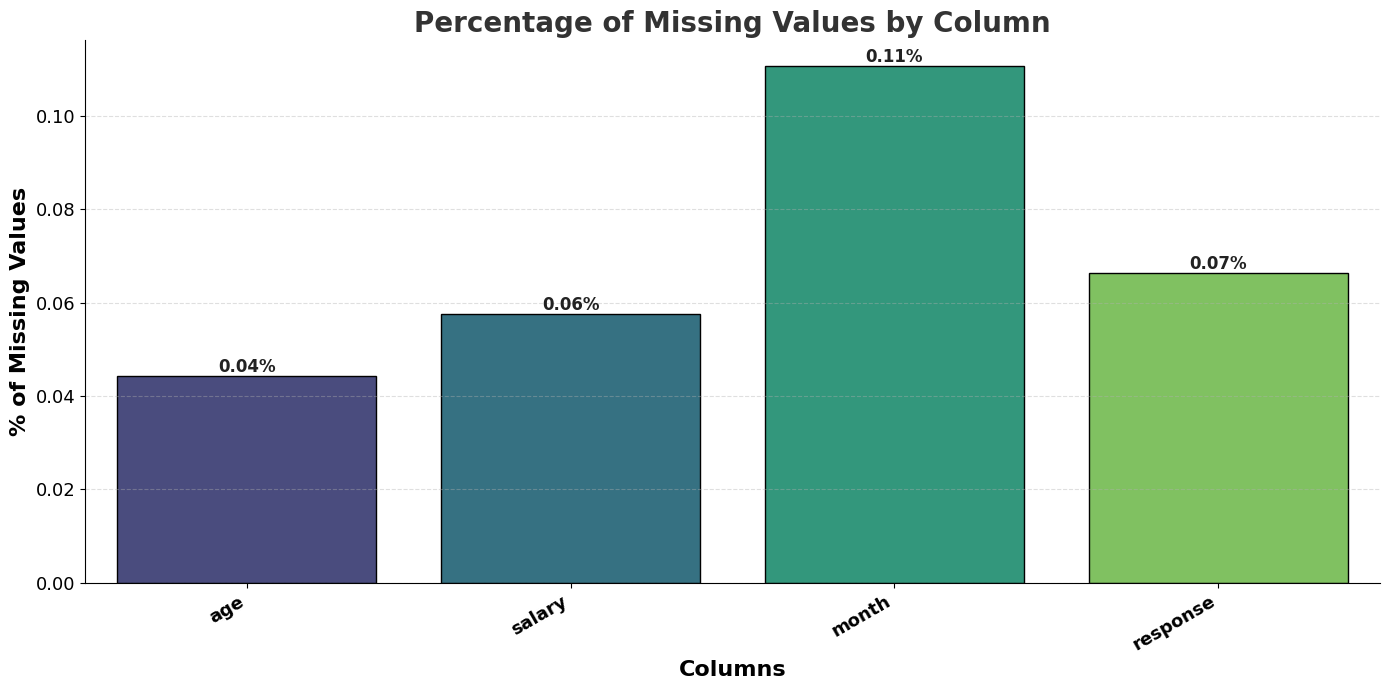

In [262]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

df_missing = pd.DataFrame({
    'Missing Values': missing_values,
    '% of Missing Values': missing_percentage
})
df_missing = df_missing[df_missing['Missing Values'] > 0]

print("Columns with missing values:")
print(df_missing)

plt.figure(figsize=(14, 7))
colors = sns.color_palette("viridis", len(df_missing))
ax = sns.barplot(
    x=df_missing.index,
    y=df_missing['% of Missing Values'],
    palette=colors,
    edgecolor='black'
)
plt.title('Percentage of Missing Values by Column', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Columns', fontsize=16, fontweight='bold')
plt.ylabel('% of Missing Values', fontsize=16, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=13, fontweight='bold')
plt.yticks(fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.4)

for p in ax.patches:
    value = p.get_height()
    if value > 0:
        ax.annotate(f'{value:.2f}%', 
                    (p.get_x() + p.get_width() / 2, value), 
                    ha='center', va='bottom', fontsize=12, color='#222222', fontweight='bold')

plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



The DataFrame shows a relatively small number of missing values compared to its total size.  
However, for the purposes of analysis and modeling, we will handle the missing values of each variable individually.  

In addition, this dataset presents an issue that may go unnoticed at first glance;  
after the initial treatment, we will revisit it to identify and properly address the problem.  

##### Month

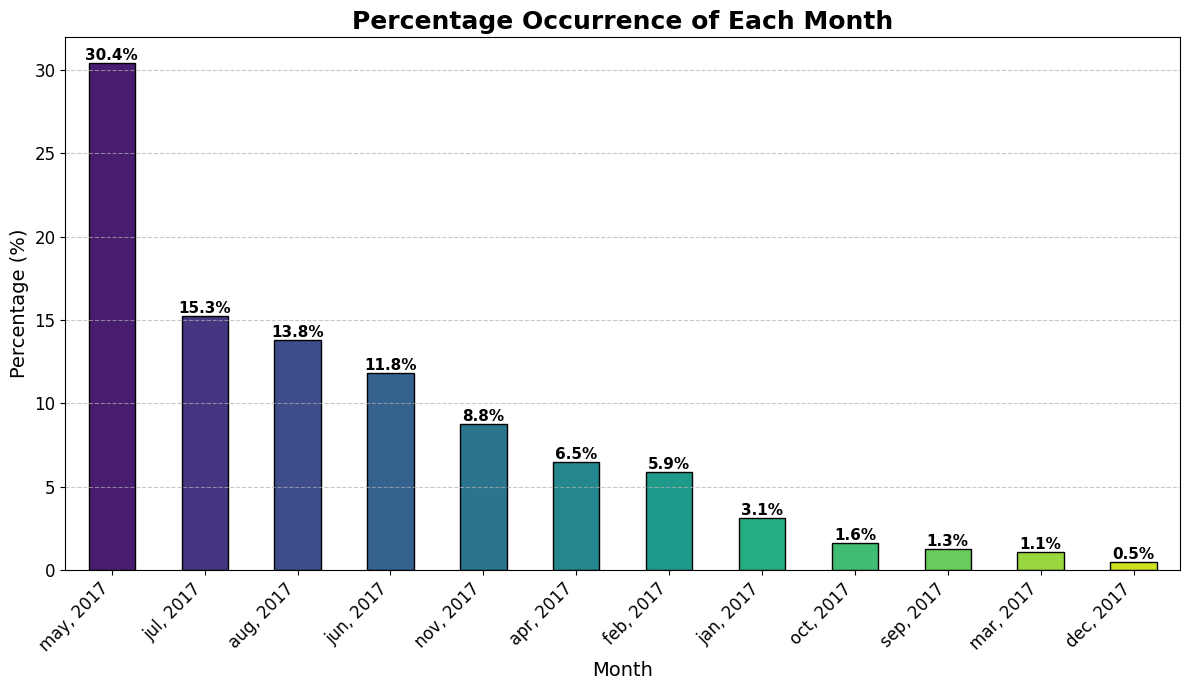

In [263]:
month_percent = df['month'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,7))
colors = sns.color_palette("viridis", len(month_percent))
ax = month_percent.sort_values(ascending=False).plot(
    kind='bar', 
    color=colors, 
    edgecolor='black'
)
plt.title('Percentage Occurrence of Each Month', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')
plt.tight_layout()
plt.show()


We can observe that the variable `month` mostly contains the value "may 2017".  
Given the small number of missing values, it would be reasonable to fill them with the mode.  

However, if there were a larger number of missing values, this approach could significantly alter the variable’s distribution, excessively increasing the frequency of "may 2017".  

Therefore, for training purposes and good practice, we will fill the missing values according to the **proportional distribution of each value** in the variable.  


In [264]:
month_distribution = df['month'].value_counts(normalize=True)
na_indices = df[df['month'].isna()].index

import numpy as np
np.random.seed(42)

fill_values = np.random.choice(
    month_distribution.index, 
    size=len(na_indices), 
    p=month_distribution.values
)

df.loc[na_indices, 'month'] = fill_values


Viewing the proportion immediately after handling the missing values:

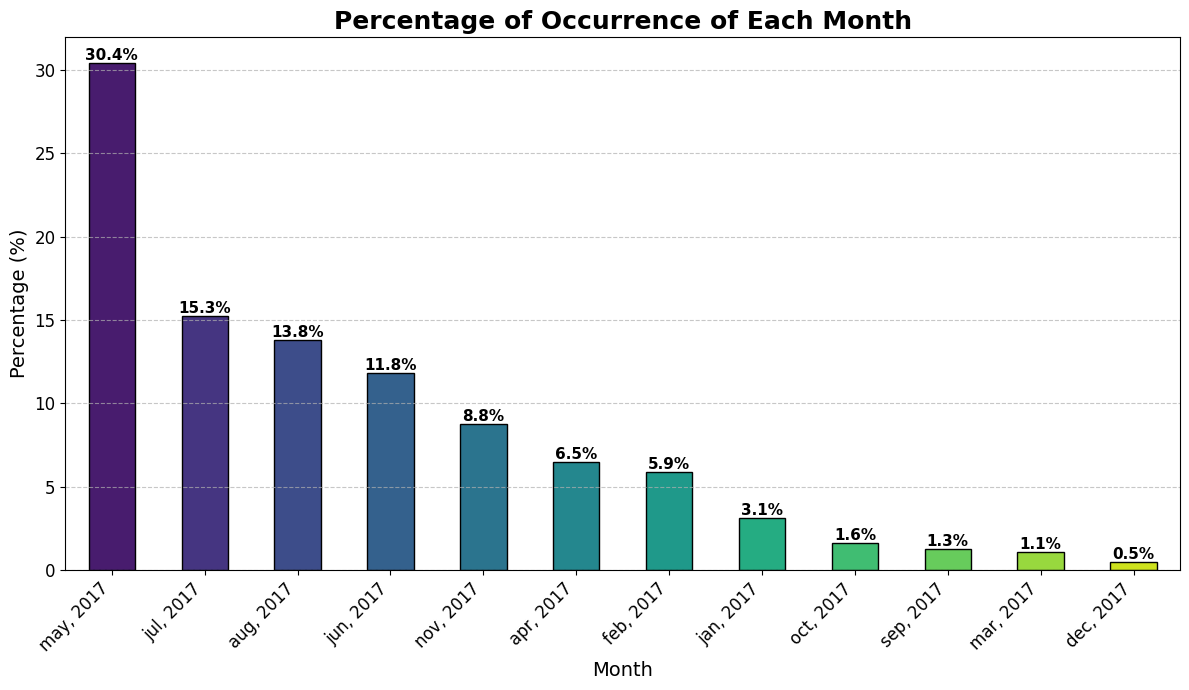

In [265]:
plt.figure(figsize=(12,7))
colors = sns.color_palette("viridis", len(month_percent))
ax = month_percent.sort_values(ascending=False).plot(
    kind='bar', 
    color=colors, 
    edgecolor='black'
)
plt.title('Percentage of Occurrence of Each Month', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

Notice how the variable’s distribution remains unchanged.



##### Age and Salary

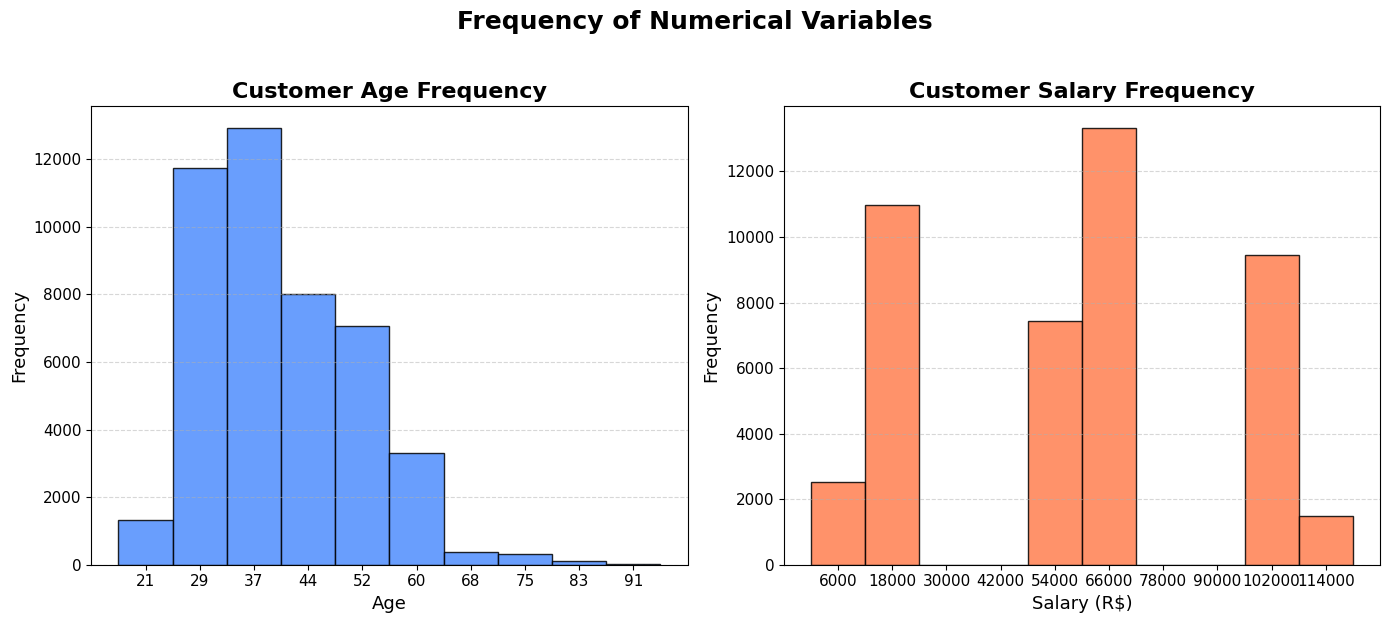

In [266]:

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
counts_age, bins_age, patches_age = plt.hist(df['age'].dropna(), bins=10, color='#4F8DFD', edgecolor='black', alpha=0.85)
centers_age = 0.5 * (bins_age[1:] + bins_age[:-1])
plt.title('Customer Age Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(centers_age, labels=[f'{int(c)}' for c in centers_age], fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.subplot(1,2,2)
counts_salary, bins_salary, patches_salary = plt.hist(df['salary'].dropna(), bins=10, color='#FF7F50', edgecolor='black', alpha=0.85)
centers_salary = 0.5 * (bins_salary[1:] + bins_salary[:-1])
plt.title('Customer Salary Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Salary (R$)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(centers_salary, labels=[f'{int(c)}' for c in centers_salary], fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Frequency of Numerical Variables', fontsize=18, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()


The variables **Salary** and **Age**, based on their observed patterns, do not appear to follow a normal distribution.  
Before drawing conclusions from visual inspection alone, we will perform formal tests to verify this hypothesis.

***But what is a normal distribution?***

The **normal distribution**, also called the Gaussian distribution, is one of the most important in statistics.  
It describes how the values of a variable are concentrated around the mean:

- Most values are close to the mean.  
- Extreme values (very high or very low) occur less frequently.  

The graph has a symmetric bell shape, and **mean, median, and mode coincide**.  
Identifying whether a variable is approximately normal is useful because many classical statistical techniques, such as hypothesis tests and regressions, assume this condition.


Testing the normality of the variables:


In [267]:

stat_age, p_age = normaltest(df['age'].dropna())
print(f"Normality test for 'age': statistic={stat_age:.4f}, p-value={p_age:.4f}")
if p_age < 0.05:
    print("The variable 'age' does NOT follow a normal distribution.")
else:
    print("The variable 'age' follows a normal distribution.")

stat_salary, p_salary = normaltest(df['salary'].dropna())
print(f"\nNormality test for 'salary': statistic={stat_salary:.4f}, p-value={p_salary:.4f}")
if p_salary < 0.05:
    print("The variable 'salary' does NOT follow a normal distribution.")
else:
    print("The variable 'salary' follows a normal distribution.")



Normality test for 'age': statistic=3067.3646, p-value=0.0000
The variable 'age' does NOT follow a normal distribution.

Normality test for 'salary': statistic=10816.2918, p-value=0.0000
The variable 'salary' does NOT follow a normal distribution.


Since both variables do not follow a normal distribution, **using the mean** to fill missing values does not make sense, as it is sensitive to extreme values and can distort the data distribution.

Two more appropriate alternatives are:

- **Median**: the central value when the data is ordered. It is resistant to outliers and preserves the central tendency even in skewed distributions.  
- **Mode**: the most frequent value in the variable. Useful when there are repeated values that we want to preserve.

The choice between median and mode depends on the type of variable and its distribution:  
- For numeric variables with dispersed or skewed values, the **median** is usually more suitable.  


In [268]:
mode_salary = df['salary'].mode()[0]
median_salary = df['salary'].median()
mean_salary = df['salary'].mean()
mode_age = df['age'].mode()[0]
median_age = df['age'].median()
mean_age = df['age'].mean()

import pandas as pd

df_mode_median_mean = pd.DataFrame({
    'Variable': ['salary', 'age'],
    'Mode': [mode_salary, mode_age],
    'Median': [median_salary, median_age],
    'Mean': [mean_salary, mean_age]
})

display(df_mode_median_mean)


,Variable,Mode,Median,Mean
0,salary,20000.0,60000.0,57008.653314
1,age,32.0,39.0,40.935651


Observing the distribution of the variables:

- For **salary**, the **mode** is far below the median and the mean.  
  Therefore, to fill the missing values, we will use the **median**, which better represents the central value of the variable and is less sensitive to extreme values.

- For **age**, filling with either the **mode** or the **median** would not make much difference, as there are few missing values.  
  We will choose to fill with the **mode**, preserving the most frequent values without significantly altering the distribution.


In [269]:
df['age'].fillna(moda_age, inplace=True)
df['salary'].fillna(mediana_salary, inplace=True)


##### Response

For the variable **response**, which is the target variable and has few missing values, we will **remove the rows with missing values**.  
This approach avoids introducing bias or distortions in the data, preserving the integrity of the analysis.


In [270]:
df = df.dropna(subset=['response'])


#### Checking for the presence of null values in the dataset.

In [271]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)


Missing values per column:
customerid    0
age           0
salary        0
balance       0
marital       0
jobedu        0
targeted      0
default       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
response      0
dtype: int64


At first glance, after applying the previous line of code, the dataset seems to have no more missing values, suggesting it is completely clean.  
However, this impression **is not entirely true**. We will see why next.


#### Unknown Values


In [272]:
df.head()


,customerid,age,salary,balance,marital,jobedu,targeted,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,1,58.0,100000.0,2143,married,"management,tertiary",yes,no,yes,no,unknown,5,"may, 2017",261 sec,1,-1,0,unknown,no
1,2,44.0,60000.0,29,single,"technician,secondary",yes,no,yes,no,unknown,5,"may, 2017",151 sec,1,-1,0,unknown,no
2,3,33.0,120000.0,2,married,"entrepreneur,secondary",yes,no,yes,yes,unknown,5,"may, 2017",76 sec,1,-1,0,unknown,no
3,4,47.0,20000.0,1506,married,"blue-collar,unknown",no,no,yes,no,unknown,5,"may, 2017",92 sec,1,-1,0,unknown,no
4,5,33.0,0.0,1,single,"unknown,unknown",no,no,no,no,unknown,5,"may, 2017",198 sec,1,-1,0,unknown,no


Some variables contain values like `'unknown'`, which in practice represent **missing values**.  
They can go unnoticed because Python often **does not automatically recognize them as `NaN`**.  
It is important to identify and handle these values to ensure the quality of the analysis.

##### Organizing Variables

First, we will separate the **job** and **education** variables.  
For analysis and cleaning purposes, it is more appropriate to **evaluate each case individually**, allowing us to identify specific patterns and inconsistencies in each variable.



In [273]:
df[['job', 'edu']] = df['jobedu'].str.split(',', expand=True)
df.drop('jobedu', axis=1, inplace=True)


Next, we will **visualize the variables that contain `'unknown'` values**.  
This will allow us to clearly identify where the hidden missing data is and plan how to properly handle it.



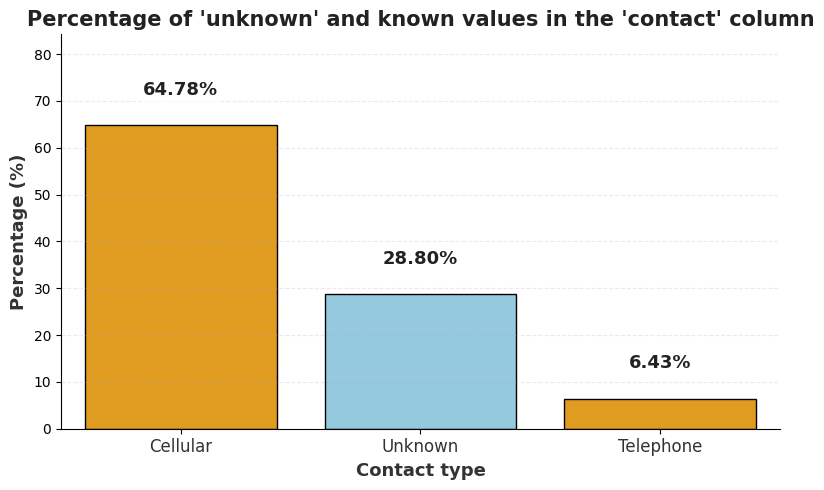

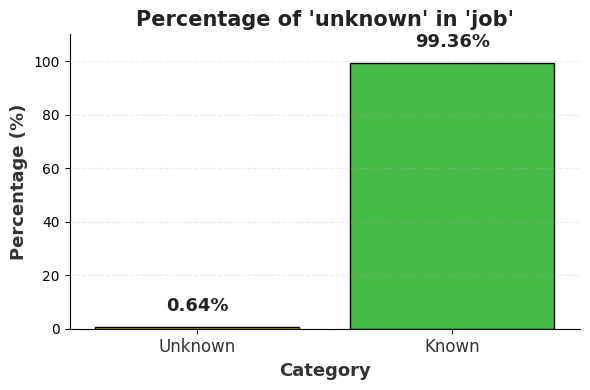

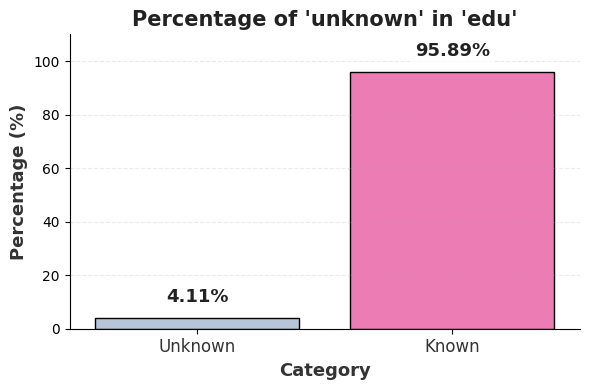

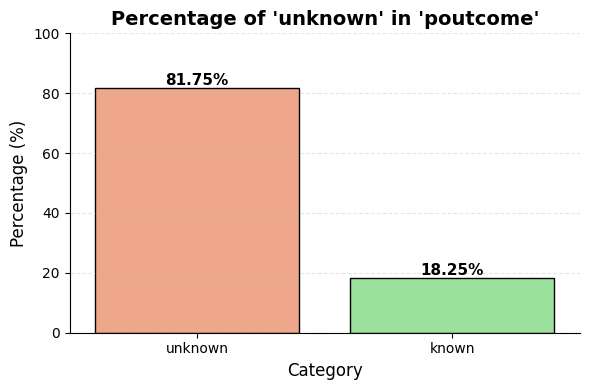

In [274]:
contact_counts = df['contact'].str.lower().value_counts()
total = contact_counts.sum()
percentages = (contact_counts / total) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = sns.barplot(
    x=percentages.index, 
    y=percentages.values, 
    palette=['#FFA500', '#87CEEB'],
    edgecolor='black',
    ax=ax
)
ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold', color='#333333')
ax.set_xlabel('Contact type', fontsize=13, fontweight='bold', color='#333333')
ax.set_title("Percentage of 'unknown' and known values in the 'contact' column", fontsize=15, fontweight='bold', color='#222222')
ax.set_ylim(0, max(percentages.values)*1.30)
ax.set_xticklabels([x.capitalize() for x in percentages.index], fontsize=12, color='#333333')
for i, v in enumerate(percentages.values):
    ax.text(i, v + (max(percentages.values)*0.10), f"{v:.2f}%", ha='center', fontsize=13, fontweight='bold', color='#222222', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.show()

job_counts = df['job'].str.lower().value_counts()
total_job = job_counts.sum()
percent_unknown_job = (job_counts.get('unknown', 0) / total_job) * 100
percent_known_job = 100 - percent_unknown_job

fig, ax2 = plt.subplots(figsize=(6, 4))
bars2 = sns.barplot(
    x=['Unknown', 'Known'],
    y=[percent_unknown_job, percent_known_job],
    palette=['#FFD700', '#32CD32'],
    edgecolor='black',
    ax=ax2
)
ax2.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold', color='#333333')
ax2.set_xlabel('Category', fontsize=13, fontweight='bold', color='#333333')
ax2.set_title("Percentage of 'unknown' in 'job'", fontsize=15, fontweight='bold', color='#222222')
ax2.set_xticklabels(['Unknown', 'Known'], fontsize=12, color='#333333')
ax2.set_ylim(0, 110)
for i, v in enumerate([percent_unknown_job, percent_known_job]):
    ax2.text(i, v + 6, f"{v:.2f}%", ha='center', fontsize=13, fontweight='bold', color='#222222', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.show()

edu_counts = df['edu'].str.lower().value_counts()
total_edu = edu_counts.sum()
percent_unknown_edu = (edu_counts.get('unknown', 0) / total_edu) * 100
percent_known_edu = 100 - percent_unknown_edu

fig, ax3 = plt.subplots(figsize=(6, 4))
bars3 = sns.barplot(
    x=['Unknown', 'Known'],
    y=[percent_unknown_edu, percent_known_edu],
    palette=['#B0C4DE', '#FF69B4'],
    edgecolor='black',
    ax=ax3
)
ax3.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold', color='#333333')
ax3.set_xlabel('Category', fontsize=13, fontweight='bold', color='#333333')
ax3.set_title("Percentage of 'unknown' in 'edu'", fontsize=15, fontweight='bold', color='#222222')
ax3.set_xticklabels(['Unknown', 'Known'], fontsize=12, color='#333333')
ax3.set_ylim(0, 110)
for i, v in enumerate([percent_unknown_edu, percent_known_edu]):
    ax3.text(i, v + 6, f"{v:.2f}%", ha='center', fontsize=13, fontweight='bold', color='#222222', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.show()

poutcome_counts = df['poutcome'].str.lower().value_counts()
total_poutcome = poutcome_counts.sum()
percent_unknown_poutcome = (poutcome_counts.get('unknown', 0) / total_poutcome) * 100
percent_known_poutcome = 100 - percent_unknown_poutcome

plt.figure(figsize=(6,4))
ax1 = sns.barplot(
    x=['unknown', 'known'],
    y=[percent_unknown_poutcome, percent_known_poutcome],
    palette=['#FFA07A', '#90EE90'],
    edgecolor='black'
)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.title("Percentage of 'unknown' in 'poutcome'", fontsize=14, fontweight='bold')
for i, v in enumerate([percent_unknown_poutcome, percent_known_poutcome]):
    ax1.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=11, fontweight='bold', color='black')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()



##### Job

The rows where the **job** variable has missing values account for **less than 1% of the total**.  
Therefore, we will choose to **remove these rows**, as the impact on the analysis will be minimal and the integrity of the data will be preserved.



In [275]:
df = df[df['job'].str.lower() != 'unknown']


##### Edu

Moving on to the other variables, we will **analyze the distribution of the `education` variable**.  
This visualization will help us understand the frequency of the different education levels, in order to fill in the missing values.



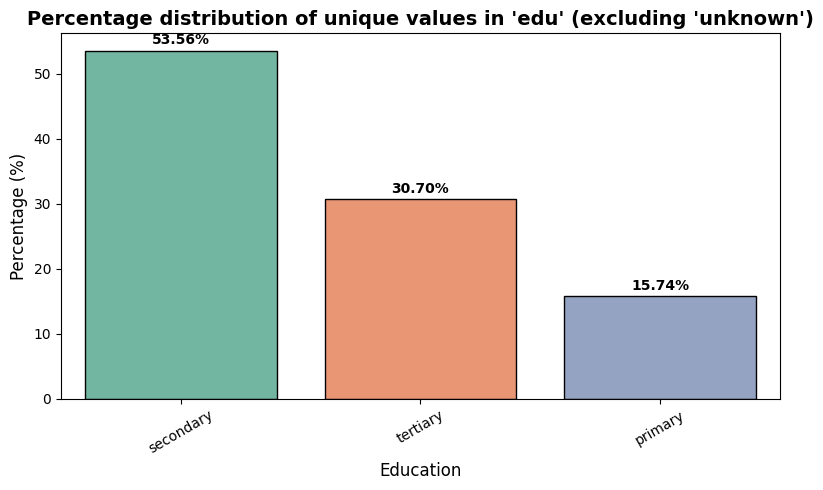

In [276]:
plt.figure(figsize=(8,5))
edu_counts = df[df['edu'].str.lower() != 'unknown']['edu'].value_counts(normalize=True) * 100
ax = sns.barplot(
    x=edu_counts.index,
    y=edu_counts.values,
    palette='Set2',
    edgecolor='black'
)
plt.title("Percentage distribution of unique values in 'edu' (excluding 'unknown')", fontsize=14, fontweight='bold')
plt.xlabel('Education', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
for i, v in enumerate(edu_counts.values):
    ax.annotate(f'{v:.2f}%', (i, v + 0.5), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Since the value **'secondary'** is very predominant in the variable,  
just as we did for the **month** variable, we will **not use the mode** to fill missing values.  
Instead, we will adopt the same proportional approach, filling missing values **according to the relative frequency of each category**.  
This strategy preserves the original distribution of the variable.


In [277]:
edu_proportions = df[df['edu'].str.lower() != 'unknown']['edu'].value_counts(normalize=True)

def fill_random_edu(val):
    if val.lower() == 'unknown':
        return np.random.choice(edu_proportions.index, p=edu_proportions.values)
    else:
        return val

df['edu'] = df['edu'].apply(fill_random_edu)

##### Contact

The **contact** variable, unlike the other two, has a **large number of missing values**.  
One possible approach would be to remove it, but it is important to consider its meaning: it indicates **the form of contact with the client**, which may have a **strong relationship with the target variable `response`**.

It is observed that the variable is **extremely imbalanced**.  
To handle this efficiently, we can **transform it into a binary variable (0 and 1)**, creating a new column:

- `contacted_cellphone = 1` → client was contacted by mobile phone  
- `contacted_cellphone = 0` → client was not contacted by mobile phone  

This way, we can **correct the variable, reduce the effects of imbalance, and facilitate the analysis of its relationship with the target variable**.



In [278]:
df['contacted_cellphone'] = df['contact'].apply(lambda x: 1 if str(x).strip().lower() == 'cellular' or str(x).strip().lower() == 'cellphone' else 0)
df = df.drop(columns=['contact'])

##### Poutcome

For the **poutcome** variable, there is no viable option other than **removing it**,  
as it has **81% missing values**.  

With such a high level of absence, the variable **does not provide useful information** for the analysis, and keeping it could distort the results.



In [279]:
df = df.drop(columns=['poutcome'])


#### "Hidden" Missing Values
Some variables contain **hidden missing values**.  
As mentioned earlier, missing values can appear simply as `NaN`,  
but they can also be represented in **unusual or unexpected ways**.  

In the following analyses, we will identify these cases to handle them properly.



##### Pdays

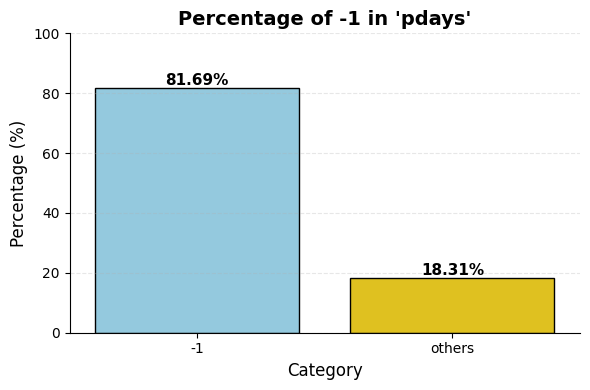

In [280]:

pdays_count = df['pdays'].value_counts()
total_pdays = pdays_count.sum()
percentage_minus1_pdays = (pdays_count.get(-1, 0) / total_pdays) * 100
percentage_other_pdays = 100 - percentage_minus1_pdays

plt.figure(figsize=(6,4))
ax2 = sns.barplot(
    x=['-1', 'others'],
    y=[percentage_minus1_pdays, percentage_other_pdays],
    palette=['#87CEEB', '#FFD700'],
    edgecolor='black'
)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.title("Percentage of -1 in 'pdays'", fontsize=14, fontweight='bold')
for i, v in enumerate([percentage_minus1_pdays, percentage_other_pdays]):
    ax2.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=11, fontweight='bold', color='black')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

When **pdays = -1**, this means that there was **no previous campaign** for that client.  

From this, we can conclude that for the variable **poutcome** (already removed),  
when `pdays` would be missing, it was probably `'unknown'` or absent.  
In other words, **the absence of `pdays` implies the absence of `poutcome`**.

**Conclusion:** the missing values in both variables likely have the **same cause**: the client **has never participated in a previous campaign**.

Although both variables could contain relevant information for the analysis, the **high number of missing values** could bias any direct study.  
However, knowing this, **we will not remove them completely**.  
Instead, we will transform the `pdays` variable into a **binary variable**, called `was_p_contacted`:

- `was_p_contacted = 1` → client participated in a previous campaign  
- `was_p_contacted = 0` → client has never participated in a previous campaign  

This way, we can **preserve the relevant information** without letting the missing values affect the analysis.


In [281]:
df['was_p_contacted'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1)
df = df.drop(columns=['pdays'])

In [282]:
df.head()

,customerid,age,salary,balance,marital,targeted,default,housing,loan,day,month,duration,campaign,previous,response,job,edu,contacted_cellphone,was_p_contacted
0,1,58.0,100000.0,2143,married,yes,no,yes,no,5,"may, 2017",261 sec,1,0,no,management,tertiary,0,0
1,2,44.0,60000.0,29,single,yes,no,yes,no,5,"may, 2017",151 sec,1,0,no,technician,secondary,0,0
2,3,33.0,120000.0,2,married,yes,no,yes,yes,5,"may, 2017",76 sec,1,0,no,entrepreneur,secondary,0,0
3,4,47.0,20000.0,1506,married,no,no,yes,no,5,"may, 2017",92 sec,1,0,no,blue-collar,primary,0,0
5,6,35.0,100000.0,231,married,yes,no,yes,no,5,"may, 2017",139 sec,1,0,no,management,tertiary,0,0


### **Normalization**

#### Duration

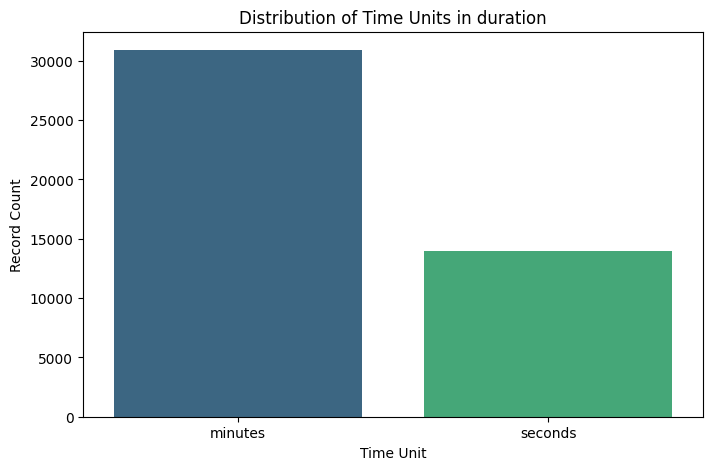

Frequency of time units in the 'duration' column:
      Unit  Count
0  minutes  30905
1  seconds  13988


In [283]:

def extract_unit(duration):
    if pd.isnull(duration):
        return 'unknown'
    duration = str(duration).lower()
    if 'sec' in duration:
        return 'seconds'
    elif 'min' in duration:
        return 'minutes'
    elif 'hour' in duration:
        return 'hours'
    else:
        return 'unknown'

df['duration_unit'] = df['duration'].apply(extract_unit)

unit_count = df['duration_unit'].value_counts().reset_index()
unit_count.columns = ['Unit', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=unit_count, x='Unit', y='Count', palette='viridis')
plt.title('Distribution of Time Units in duration')
plt.xlabel('Time Unit')
plt.ylabel('Record Count')
plt.show()

print("Frequency of time units in the 'duration' column:")
print(unit_count)

df.drop('duration_unit', axis=1, inplace=True)



We can observe that the data in the **duration** variable, which represents call length, is split between **seconds and minutes**.  

For analysis purposes, this is not ideal, as it complicates interpretation and handling of the variable.  
We can **convert the variable to numeric** and **standardize all durations to a single unit** (seconds or minutes), ensuring consistency in the data.



In [284]:

def extract_duration_sec(value):
    if isinstance(value, str) and 'sec' in value:
        match = re.search(r'(\d+)', value)
        if match:
            return float(match.group(1))
    return np.nan

def extract_duration_min(value):
    if isinstance(value, str) and 'min' in value:
        match = re.search(r'(\d+)', value)
        if match:
            return float(match.group(1))
    return np.nan

df['duration(s)'] = df['duration'].apply(extract_duration_sec)
df['duration(m)'] = df['duration'].apply(extract_duration_min)

df['duration(m)'] = df['duration(m)'] * 60

df['duration'] = df.apply(
    lambda row: row['duration(m)'] if not pd.isna(row['duration(m)']) else row['duration(s)'],
    axis=1
)

df = df.drop(columns=['duration(m)', 'duration(s)'])

We chose **seconds** as the unit for the `duration` variable,  
as it is a more **universal and precise** unit.  

If we had chosen **minutes**, interpreting the variable could be less clear,  
especially when dealing with very short or very long durations.


#### Month

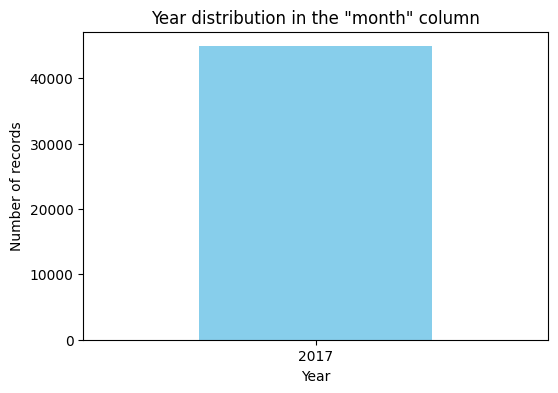

Unique years found in the 'month' column: ['2017']


In [285]:

df['year'] = df['month'].apply(lambda x: str(x).split(',')[-1].strip() if isinstance(x, str) and ',' in x else x)

year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(6,4))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Year distribution in the "month" column')
plt.xlabel('Year')
plt.ylabel('Number of records')
plt.xticks(rotation=0)
plt.show()

print("Unique years found in the 'month' column:", df['year'].unique())

df = df.drop(columns=['year'])




The **month** column contains only data from the year 2017.  

Keeping the value "2017" after the month names **does not add relevant information** and may **interfere with grouping or statistical calculations**.  

Therefore, we will **remove the year part**, keeping only the month names.



In [286]:
df['month'] = df['month'].apply(lambda x: str(x).split(',')[0].strip() if isinstance(x, str) and ',' in x else x)


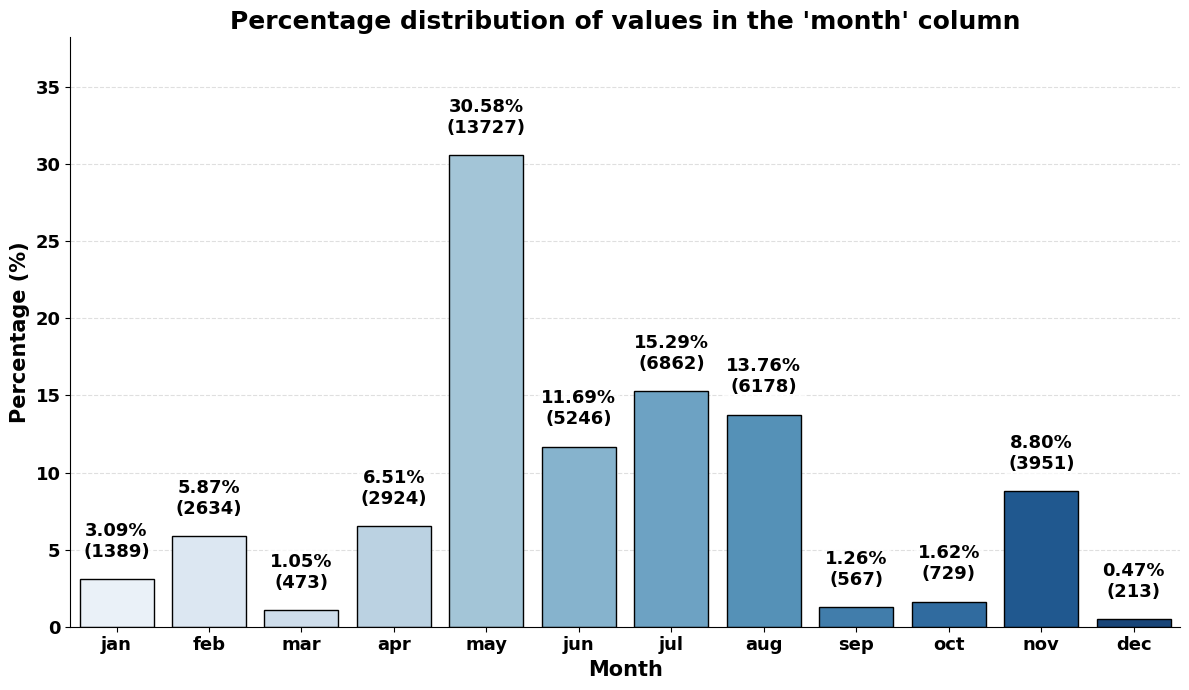

In [287]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['month'] = df['month'].str.lower()

month_counts = df['month'].value_counts().reindex(month_order).fillna(0)
month_percent = (month_counts / month_counts.sum()) * 100

plt.figure(figsize=(12,7))
ax = sns.barplot(
    x=month_counts.index, 
    y=month_percent.values, 
    palette='Blues', 
    edgecolor='black'
)

plt.ylabel('Percentage (%)', fontsize=15, fontweight='bold')
plt.xlabel('Month', fontsize=15, fontweight='bold')
plt.title("Percentage distribution of values in the 'month' column", fontsize=18, fontweight='bold')

for i, (v, n) in enumerate(zip(month_percent.values, month_counts.values)):
    ax.text(i, v + 1.2, f"{v:.2f}%\n({int(n)})", 
            ha='center', va='bottom', fontsize=13, fontweight='bold', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

plt.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)
sns.despine()
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.ylim(0, max(month_percent.values)*1.25)
plt.tight_layout()
plt.show()

Additionally, the **month** variable shows **extreme imbalance**,  
with some months having fewer than a thousand records.  

To improve data balance and facilitate analysis, we will **group the months into quarters**.  
This way, we will have more balanced categories and a clearer view of the temporal distribution.


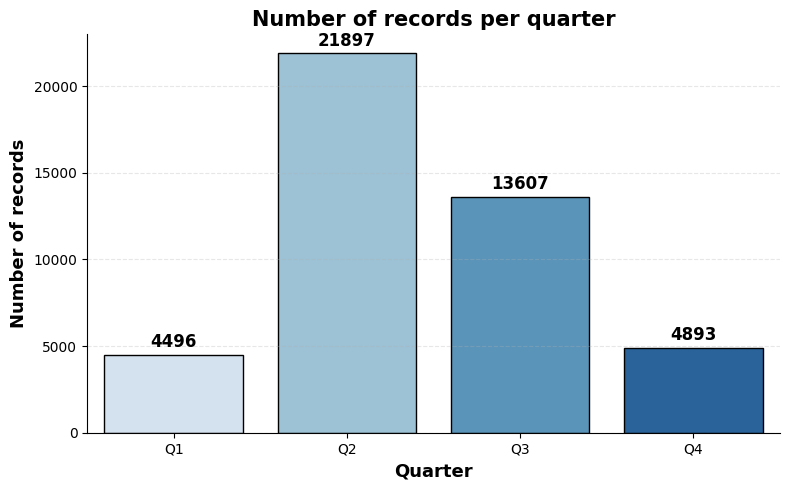

In [288]:
quarter_map = {
    'jan': 'Q1', 'feb': 'Q1', 'mar': 'Q1',
    'apr': 'Q2', 'may': 'Q2', 'jun': 'Q2',
    'jul': 'Q3', 'aug': 'Q3', 'sep': 'Q3',
    'oct': 'Q4', 'nov': 'Q4', 'dec': 'Q4'
}

df['quarter'] = df['month'].map(quarter_map)

quarter_counts = df['quarter'].value_counts().sort_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=quarter_counts.index,
    y=quarter_counts.values,
    palette='Blues',
    edgecolor='black'
)
plt.ylabel('Number of records', fontsize=13, fontweight='bold')
plt.xlabel('Quarter', fontsize=13, fontweight='bold')
plt.title('Number of records per quarter', fontsize=15, fontweight='bold')
for i, v in enumerate(quarter_counts.values):
    ax.text(i, v + max(quarter_counts.values)*0.01, f"{v}", ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


Even after grouping into quarters, the variable still remains **extremely imbalanced**.  

To simplify and improve balance, we will **group the months into semesters**.  
This approach creates more balanced categories, facilitating analyses and statistical comparisons.



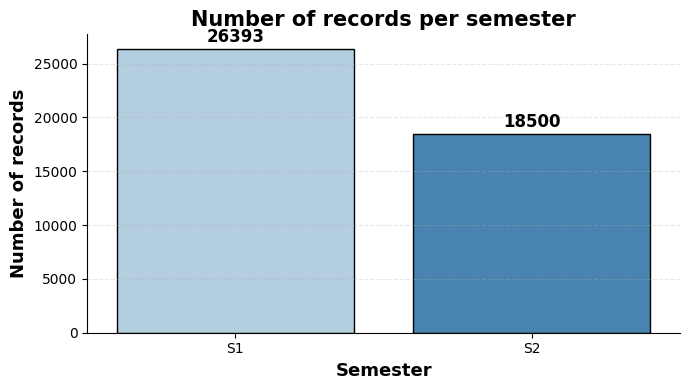

In [289]:
semester_map = {
    'jan': 'S1', 'feb': 'S1', 'mar': 'S1',
    'apr': 'S1', 'may': 'S1', 'jun': 'S1',
    'jul': 'S2', 'aug': 'S2', 'sep': 'S2',
    'oct': 'S2', 'nov': 'S2', 'dec': 'S2'
}

df['semester_2017'] = df['month'].map(semester_map)

semester_counts = df['semester_2017'].value_counts().sort_index()

plt.figure(figsize=(7,4))
ax = sns.barplot(
    x=semester_counts.index,
    y=semester_counts.values,
    palette='Blues',
    edgecolor='black'
)
plt.ylabel('Number of records', fontsize=13, fontweight='bold')
plt.xlabel('Semester', fontsize=13, fontweight='bold')
plt.title('Number of records per semester', fontsize=15, fontweight='bold')
for i, v in enumerate(semester_counts.values):
    ax.text(i, v + max(semester_counts.values)*0.01, f"{v}", ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


Now, the variable is **better balanced** for analysis.  

If we had conducted the analysis using the months in their original format,  
there would be a risk of interpreting a **real trend** where, in fact, it is merely a reflection of the **imbalance in the number of records per group**.



In [290]:
df = df.drop(columns=['month', 'quarter'])


#### Customerid

We will **remove the `customerid` column**, as it **does not contribute to the analysis** and will not be used in the models.


In [291]:
df = df.drop(columns=['customerid'])



In [292]:
df.head()

,age,salary,balance,marital,targeted,default,housing,loan,day,duration,campaign,previous,response,job,edu,contacted_cellphone,was_p_contacted,semester_2017
0,58.0,100000.0,2143,married,yes,no,yes,no,5,261.0,1,0,no,management,tertiary,0,0,S1
1,44.0,60000.0,29,single,yes,no,yes,no,5,151.0,1,0,no,technician,secondary,0,0,S1
2,33.0,120000.0,2,married,yes,no,yes,yes,5,76.0,1,0,no,entrepreneur,secondary,0,0,S1
3,47.0,20000.0,1506,married,no,no,yes,no,5,92.0,1,0,no,blue-collar,primary,0,0,S1
5,35.0,100000.0,231,married,yes,no,yes,no,5,139.0,1,0,no,management,tertiary,0,0,S1


#### Binaries

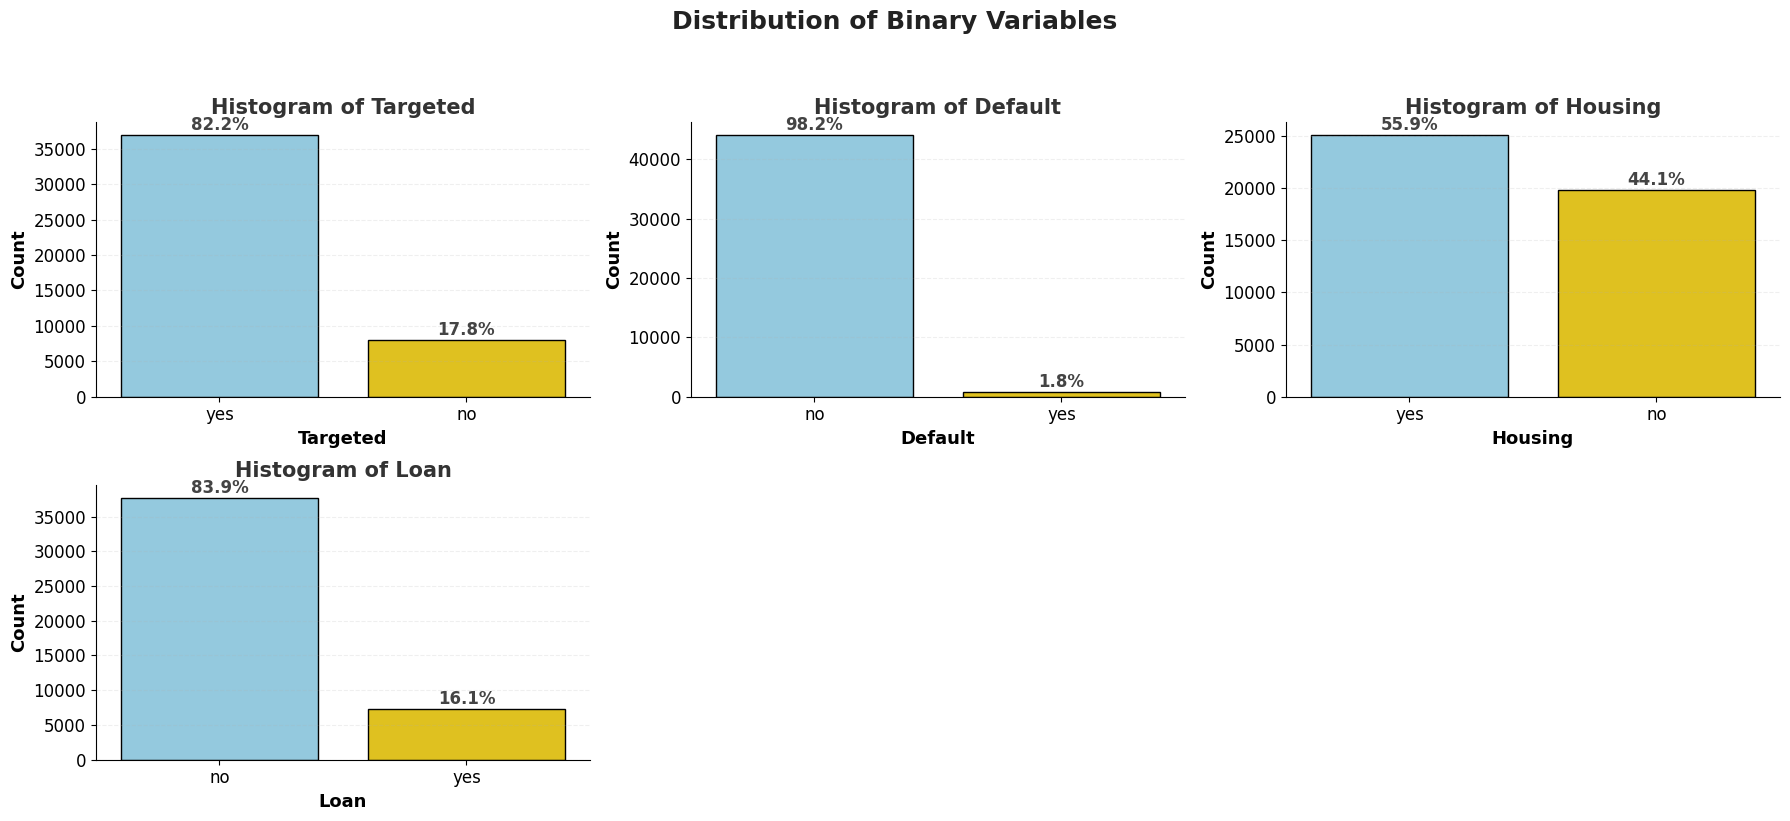

In [293]:

columns = ['targeted', 'default', 'housing', 'loan']
colors = ['#87CEEB', '#FFD700']

plt.figure(figsize=(18, 8))
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    values = df[column].value_counts()
    percentages = df[column].value_counts(normalize=True) * 100
    ax = sns.barplot(
        x=values.index, 
        y=values.values, 
        palette=colors[:len(values)], 
        edgecolor='black'
    )
    plt.title(f'Histogram of {column.capitalize()}', fontsize=15, fontweight='bold', color='#333333')
    plt.xlabel(column.capitalize(), fontsize=13, fontweight='bold')
    plt.ylabel('Count', fontsize=13, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    sns.despine()
    for j, (value, count) in enumerate(values.items()):
        pct = percentages[value]
        ax.text(j, count + max(values)*0.02, f'{pct:.1f}%', 
                ha='center', fontsize=12, fontweight='bold', color='#444444')
plt.suptitle('Distribution of Binary Variables', fontsize=18, fontweight='bold', color='#222222', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


Some variables show **significant imbalance**,  
but we will still **keep those where the least frequent category represents more than 10% of the records**,  
until we are sure they have no relationship with the target variable.  

To facilitate and **speed up the analysis**, these variables will be **converted to boolean type**.


In [294]:
df = df.drop(columns=['default'])


In [295]:
colunas_bool = ['targeted', 'housing', 'loan', 'response']
for coluna in colunas_bool:
    df[coluna] = df[coluna].map({'yes': 1, 'no': 0})


In [296]:
df.head()

,age,salary,balance,marital,targeted,housing,loan,day,duration,campaign,previous,response,job,edu,contacted_cellphone,was_p_contacted,semester_2017
0,58.0,100000.0,2143,married,1,1,0,5,261.0,1,0,0,management,tertiary,0,0,S1
1,44.0,60000.0,29,single,1,1,0,5,151.0,1,0,0,technician,secondary,0,0,S1
2,33.0,120000.0,2,married,1,1,1,5,76.0,1,0,0,entrepreneur,secondary,0,0,S1
3,47.0,20000.0,1506,married,0,1,0,5,92.0,1,0,0,blue-collar,primary,0,0,S1
5,35.0,100000.0,231,married,1,1,0,5,139.0,1,0,0,management,tertiary,0,0,S1


### **Verificando Valores nulos novamente**.

After making the data modifications, it is **important to check for any new missing values**.  
This check ensures that the cleaning and transformation of variables have not introduced inconsistencies or unexpected gaps.


In [297]:
missing_values = df.isnull().sum()
print("Missing values per column after transformations:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")


Missing values per column after transformations:
No missing values found.


### **Outlier**

Once missing values and data types have been addressed, we will proceed to identify outlier values:

In [298]:

outlier_columns = ['age', 'balance', 'campaign', 'duration', 'previous']

for column in outlier_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    num_outliers = outliers.shape[0]
    total = df.shape[0]
    percentage = (num_outliers / total) * 100

    print(f"Column: {column}")
    print(f"Number of outliers: {num_outliers}")
    print(f"Percentage of outliers: {percentage:.2f}%\n")


Column: age
Number of outliers: 480
Percentage of outliers: 1.07%

Column: balance
Number of outliers: 4711
Percentage of outliers: 10.49%

Column: campaign
Number of outliers: 3029
Percentage of outliers: 6.75%

Column: duration
Number of outliers: 3050
Percentage of outliers: 6.79%

Column: previous
Number of outliers: 8218
Percentage of outliers: 18.31%



#### Observations
- The variables **balance**, **campaign**, **duration**, and **previous** have considerable proportions of outliers, above 5%.  
- Notably, **previous** has **18.31% outliers**, which may significantly impact the analysis.  
- The **age** variable has few outliers (1.07%), making it less concerning. 

We will replace the outliers with the limits (Fences). But what exactly are the limits?

#### Outlier Treatment with Fences

In statistics, to handle extreme values, we use **quartiles**:

- **Quartiles**: divide the data into four equal parts.  
- The **first quartile (Q1)** is the point below which 25% of the data lie.  
- The **third quartile (Q3)** is the point below which 75% of the data lie.  
- The difference between these two points is called the **interquartile range (IQR)**, which shows the “normal range” where the data usually fall.

Based on the IQR, we create two **limits (fences)**:  
- **Lower fence**: identifies very low values.  
- **Upper fence**: identifies very high values.  

All values beyond these limits are considered **outliers**.

Instead of simply removing these outliers, we can **replace them with the respective limits**:  
- If a value is much higher than expected (e.g., 500 years in an age dataset), we replace it with the **highest acceptable value** within the limit.  
- If a value is much lower than expected (e.g., negative age), we replace it with the **lowest acceptable value** within the limit.  

This way, we retain all records in the dataset while preventing extreme values from affecting the analysis.

This technique is especially useful when we believe that outliers do not represent errors, but rather rare values that could distort statistical analysis.



In [299]:
columns_replace = ['campaign', 'duration', 'balance', 'age']

for column in columns_replace:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] < lower_fence, lower_fence, df[column])
    df[column] = np.where(df[column] > upper_fence, upper_fence, df[column])



### **Correlation**

#### Spearman Correlation

To understand how the variables relate to the target variable **Response**, we can use the **Spearman correlation coefficient**.

This coefficient measures the **strength and direction of the monotonic relationship** between two variables.  
This means it does not depend on the relationship being exactly linear (as with Pearson correlation), but rather on whether the variables **tend to increase or decrease together**.

- If the coefficient is **close to +1**, it indicates that as one variable increases, the other also tends to increase.  
- If it is **close to -1**, it indicates that as one variable increases, the other tends to decrease.  
- If it is **close to 0**, it means there is no clear monotonic relationship between them.

Spearman is calculated from the **ranking** of values, not directly from the raw numbers.  
This makes it especially useful for variables that do not follow a normal distribution or have different scales.

Example:

Imagine we have 5 students.  
We measure **two different things**: their **exam score** and their **placement in a running competition**.

| Student | Exam Score | Race Placement |
|---------|------------|----------------|
| A       | 9.5        | 1st             |
| B       | 8.7        | 2nd             |
| C       | 7.0        | 3rd             |
| D       | 5.5        | 4th             |
| E       | 4.0        | 5th             |

Observing this, **the higher the score, the better the placement in the race** (1st is better than 5th).  
In other words, there is a **strong positive Spearman correlation**.

Now, imagine the table was like this:

| Student | Exam Score | Race Placement |
|---------|------------|----------------|
| A       | 9.5        | 5th             |
| B       | 8.7        | 4th             |
| C       | 7.0        | 3rd             |
| D       | 5.5        | 2nd             |
| E       | 4.0        | 1st             |

In this case, the highest scorers got the worst placements in the race.  
This shows a **negative Spearman correlation**.

If the placements were random, unrelated to the scores, the result would be **close to zero**.


In [300]:

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

spearman_corr_response = df[numeric_columns].corrwith(df['response'], method='spearman')

print("Spearman coefficient between numeric variables and the 'response' variable:")
print(spearman_corr_response)


Spearman coefficient between numeric variables and the 'response' variable:
age                   -0.008877
salary                 0.011636
balance                0.101186
targeted              -0.068917
housing               -0.140035
loan                  -0.068697
day                   -0.029804
duration               0.326767
campaign              -0.083100
previous               0.168089
response               1.000000
contacted_cellphone    0.135142
was_p_contacted        0.166191
dtype: float64


After calculating the **Spearman correlation** coefficient between the numeric variables and the `response` variable, we found the following highlights:

- **`duration` (0.3267)**  
  It is the variable with the **highest positive correlation** with the response.  
  This indicates that **the longer the call duration, the higher the chance of a positive response**.  
  This makes sense, as a longer call suggests **greater client interest**.

- **`previous` (0.1681), `was_p_contacted` (0.1662), and `contacted_cellphone` (0.1351)**  
  Show **moderate positive correlations**.  
  This indicates that clients who were **previously contacted** or **contacted via cellphone** are more likely to respond positively.

- **`balance` (0.1012)**  
  Small positive correlation. Still, it suggests that **clients with higher account balances tend to respond more**.

- **`housing` (-0.1400)**  
  **Moderate negative correlation**.  
  Indicates that clients with **housing loans** are less likely to respond positively.

- **Other variables (`age`, `salary`, `campaign`, `loan`, `default`, `day`, `targeted`)**  
  Have **coefficients close to zero**, meaning **little or no monotonic relationship** with the response variable.

---

**Conclusion:**  
The most relevant factors to predict a positive response are:  
- **Call duration** (strong indicator of interest).  
- **Previous contact history** (clients previously contacted tend to respond better).  
- **Contact channel (cellphone)**, which appears more effective.  
- **Financial situation** (positive balance helps, while housing loans reduce likelihood).


#### Graphical Analysis I

In addition to using the Spearman coefficient to evaluate the correlation between the variables and the target variable (`response`), we will also **visualize each variable graphically**.  

This step is important because, often, numerical correlation may not fully capture the behavior of the data.  
Graphical analysis allows us to **confirm trends, identify hidden patterns, and avoid discarding variables that may be relevant** for interpretation.


##### Duration

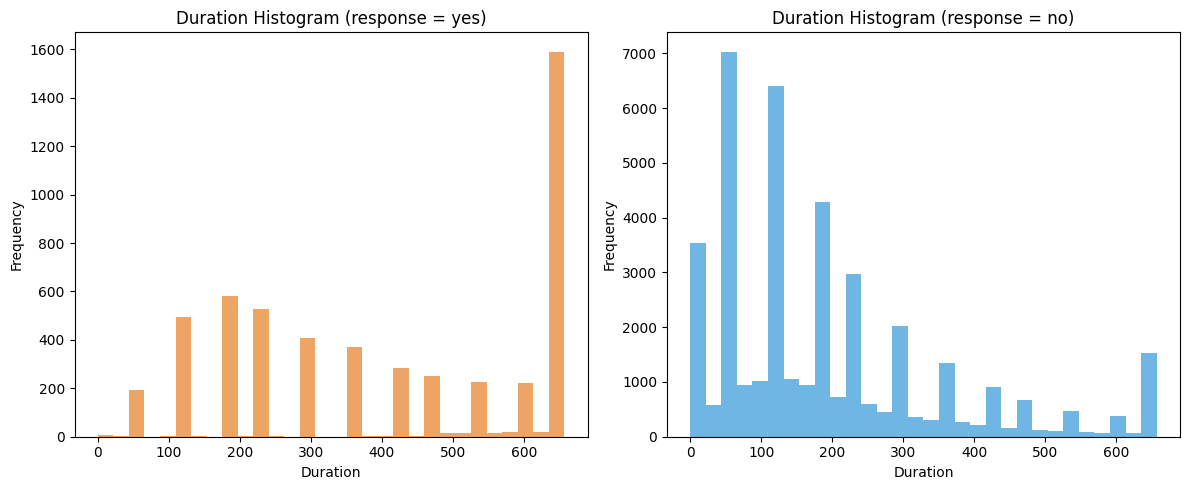

In [301]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(df[df['response'] == 1]['duration'], bins=30, color='#e67e22', alpha=0.7)
plt.title('Duration Histogram (response = yes)')
plt.xlabel('Duration')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df[df['response'] == 0]['duration'], bins=30, color='#3498db', alpha=0.7)
plt.title('Duration Histogram (response = no)')
plt.xlabel('Duration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- **Response = 1 (Yes):**
  - There is a higher concentration in the last interval (~600 seconds).  
  - The distribution is more uniform over call duration compared to the "no" cases.  
  - This indicates that **longer calls are associated with a higher chance of conversion** (as seen in Spearman correlation).

- **Response = 0 (No):**
  - Most calls fall between 0 and 200 seconds.  
  - The distribution is heavily skewed toward lower values, reflecting short calls.  
  - Even among the longer calls, the conversion rate remains low.



##### Was_p_contacted

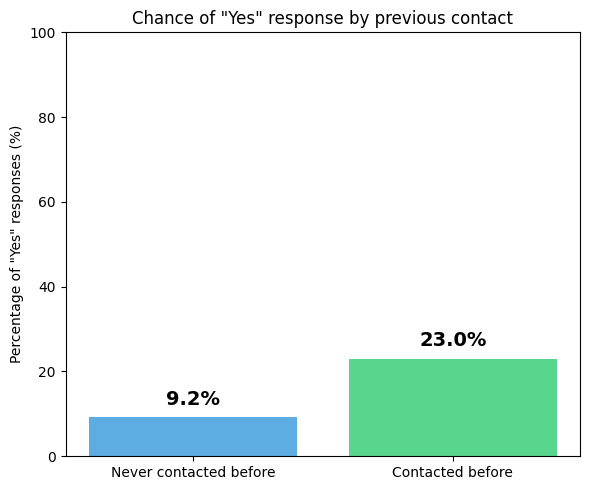

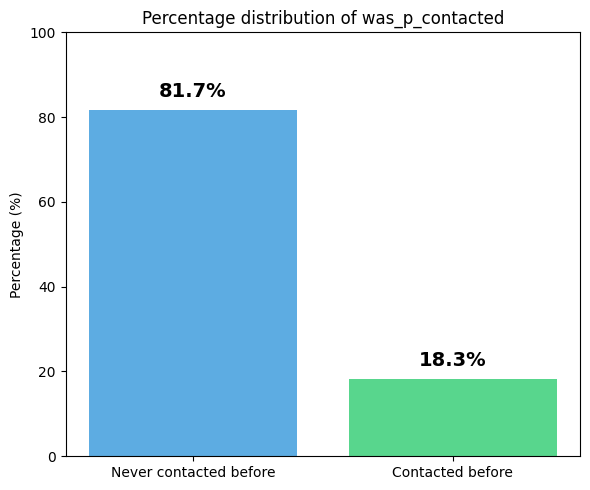

In [302]:

conversion_rate = df.groupby('was_p_contacted')['response'].mean().reset_index()
conversion_rate.columns = ['was_p_contacted', 'response_yes_rate']
conversion_rate['response_yes_rate'] = conversion_rate['response_yes_rate'] * 100
labels = {0: 'Never contacted before', 1: 'Contacted before'}
conversion_rate['was_p_contacted'] = conversion_rate['was_p_contacted'].map(labels)

plt.figure(figsize=(6,5))
plt.bar(
    conversion_rate['was_p_contacted'],
    conversion_rate['response_yes_rate'],
    color=['#3498db', '#2ecc71'],
    alpha=0.8
)
plt.ylim(0, 100)
plt.ylabel('Percentage of "Yes" responses (%)')
plt.title('Chance of "Yes" response by previous contact')

for i, v in enumerate(conversion_rate['response_yes_rate']):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

count = df['was_p_contacted'].value_counts(normalize=True) * 100
labels = {0: 'Never contacted before', 1: 'Contacted before'}
count.index = count.index.map(labels)

plt.figure(figsize=(6,5))
plt.bar(count.index, count.values, color=['#3498db', '#2ecc71'], alpha=0.8)
plt.ylim(0, 100)
plt.ylabel('Percentage (%)')
plt.title('Percentage distribution of was_p_contacted')

for i, v in enumerate(count.values):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

- Only **18.3%** of clients had been contacted previously.  
- Within this group, the positive response rate was **23%**, more than double the rate of clients who had never been contacted (**9.2%**).  
- This shows that **contact history is strongly associated with a higher chance of conversion**, even though it represents a smaller portion of the dataset.


##### Balance

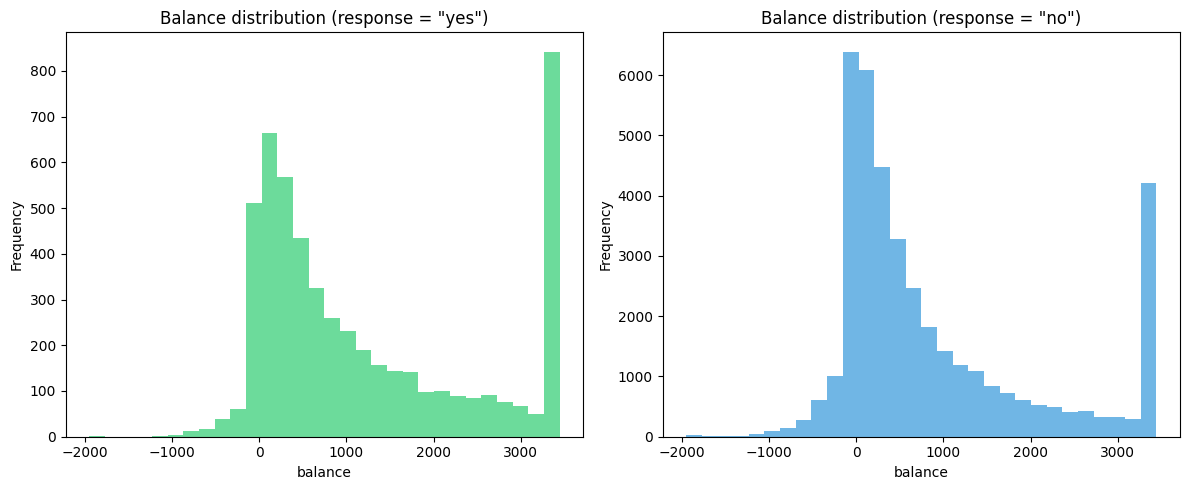

In [303]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df[df['response'] == 1]['balance'], bins=30, color='#2ecc71', alpha=0.7)
plt.title('Balance distribution (response = "yes")')
plt.xlabel('balance')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(df[df['response'] == 0]['balance'], bins=30, color='#3498db', alpha=0.7)
plt.title('Balance distribution (response = "no")')
plt.xlabel('balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



- **Response = "yes":**
  - The distribution is more spread out at higher values, indicating that **more clients with high positive balances accepted the offer**.  
  - There is a pronounced peak at the upper limit (above 3,000), showing that **clients with very high balances have a higher conversion rate**.

- **Response = "no":**
  - Most clients are concentrated between 0 and 1,000, with lower density for higher balances.  
  - There is a peak at the end (above 3,000), but proportionally smaller than in the "yes" group.


##### Previous

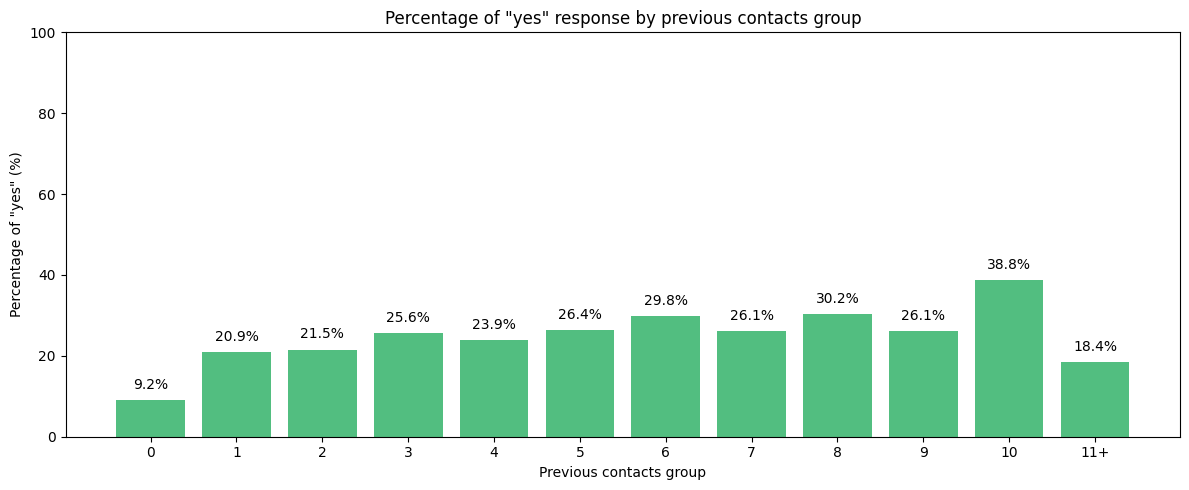

In [304]:
bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')]
labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11+'
]
df['previous_group'] = pd.cut(df['previous'], bins=bins, labels=labels, right=True)

percentage_yes = df.groupby('previous_group')['response'].mean() * 100

plt.figure(figsize=(12,5))
bars = plt.bar(percentage_yes.index.astype(str), percentage_yes.values, color='#27ae60', alpha=0.8)
plt.ylabel('Percentage of "yes" (%)')
plt.xlabel('Previous contacts group')
plt.title('Percentage of "yes" response by previous contacts group')
plt.ylim(0, 100)

for bar, percentage in zip(bars, percentage_yes.values):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 2, 
        f'{percentage:.1f}%', 
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()
del df['previous_group']


- **Previous contact increases the conversion rate:**  
  - Having **at least one prior contact** more than doubles the chance of acceptance, showing that engaged clients tend to respond better.

- **Limit of the effect:**  
  - In the group with **11 or more contacts**, a drop in the conversion rate is observed.  
  - This suggests **saturation or aversion to persistence**, indicating that multiple contacts may have the opposite effect.


##### Housing


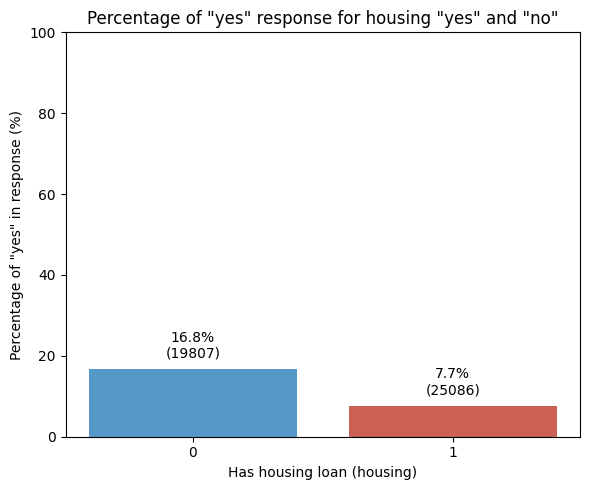

In [305]:
percentage_response_housing = df.groupby('housing')['response'].mean() * 100
count_housing = df['housing'].value_counts().sort_index()

plt.figure(figsize=(6,5))
bars = plt.bar(percentage_response_housing.index.astype(str), percentage_response_housing.values, color=['#2980b9', '#c0392b'], alpha=0.8)
plt.ylabel('Percentage of "yes" in response (%)')
plt.xlabel('Has housing loan (housing)')
plt.title('Percentage of "yes" response for housing "yes" and "no"')
plt.ylim(0, 100)

for bar, percentage, total in zip(bars, percentage_response_housing.values, count_housing.values):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 2, 
        f'{percentage:.1f}%\n({total})', 
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


- Clients **without a housing loan** have **more than double the chance** of accepting the offer compared to clients with a loan.  
- Observing the numbers:  
  - Without a loan: **16.8%** positive response  
  - With a loan: **7.7%** positive response  
- This indicates that having a **housing loan is negatively associated with the probability of conversion**.


##### Contacted_cellphone

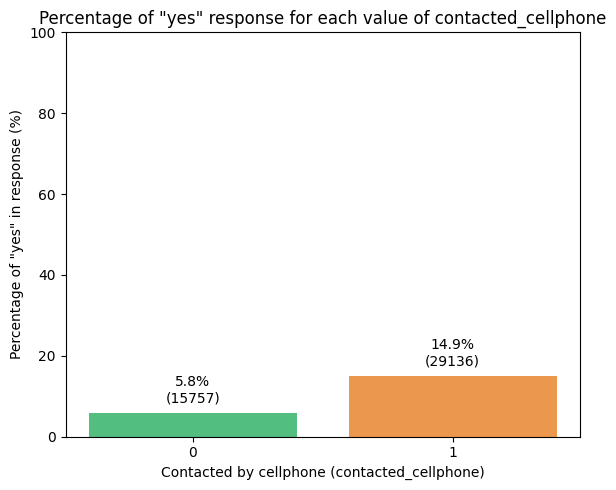

In [306]:
percentage_response_cell = df.groupby('contacted_cellphone')['response'].mean() * 100
count_cell = df['contacted_cellphone'].value_counts().sort_index()

plt.figure(figsize=(6,5))
bars = plt.bar(percentage_response_cell.index.astype(str), percentage_response_cell.values, color=['#27ae60', '#e67e22'], alpha=0.8)
plt.ylabel('Percentage of "yes" in response (%)')
plt.xlabel('Contacted by cellphone (contacted_cellphone)')
plt.title('Percentage of "yes" response for each value of contacted_cellphone')
plt.ylim(0, 100)

for bar, percentage, total in zip(bars, percentage_response_cell.values, count_cell.values):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 2, 
        f'{percentage:.1f}%\n({total})', 
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


- Clients **not contacted via cellphone**: 5.8% acceptance (n=15,757)  
- Clients **contacted via cellphone**: 14.9% acceptance (n=29,136)  

Contact via cellphone almost **triples the chance of a positive response**, making it a much more effective channel compared to others.

#### Graphical Analysis II

The variables analyzed showed a confirmed relationship with the client's response, according to the Spearman coefficient.  

Now, for the remaining variables that **did not show significant correlation**, we will perform a graphical analysis to ensure that they indeed have no relevant relationship with the target variable.

##### Day, Age and Salary

To facilitate the analysis, some continuous variables will be grouped into **bins**, allowing us to observe patterns that may not be evident in their original form.  

- **Day:** will be transformed into day intervals, enabling us to identify if certain periods concentrate higher conversion rates.  
- **Age:** will be grouped into age ranges, which helps determine if offer acceptance varies with the client's age.  
- **Salary (balance):** will also be organized into value ranges to evaluate whether income influences the response decision.  

This approach makes interpretation more intuitive and can reveal relationships that would be masked by the dispersion of individual data points.


In [307]:

bins_salary = [0, 20000, 60000, 80000, 100000, float('inf')]
labels_salary = ['<=20k', '20k-60k', '60k-80k', '80k-100k', '100k+']
df['salary_bin'] = pd.cut(df['salary'], bins=bins_salary, labels=labels_salary, right=True, include_lowest=True)

min_day = df['day'].min()
max_day = df['day'].max()
bins_day = list(range(int(min_day), int(max_day) + 8, 8))
labels_day = [f"{bins_day[i]} to {bins_day[i+1]}" for i in range(len(bins_day)-1)]
df['day_bin'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

min_age = max(18, int(df['age'].min()))
max_age = int(df['age'].max())
bins_age = list(range(min_age, max_age + 15, 15))
labels_age = [f"{bins_age[i]} to {bins_age[i+1]} years" for i in range(len(bins_age)-1)]
df['age_bin'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

df_bins_final = df[['day_bin', 'age_bin', 'salary_bin', 'response']].copy()

In [308]:
# Exibindo as primeiras linhas do novo DataFrame
df_faixas_final.head()


,day_faixa,age_faixa,salary_faixa,response
0,1 a 9,48 a 63 anos,80k-100k,0
1,1 a 9,33 a 48 anos,20k-60k,0
2,1 a 9,18 a 33 anos,100k+,0
3,1 a 9,33 a 48 anos,<=20k,0
5,1 a 9,33 a 48 anos,80k-100k,0


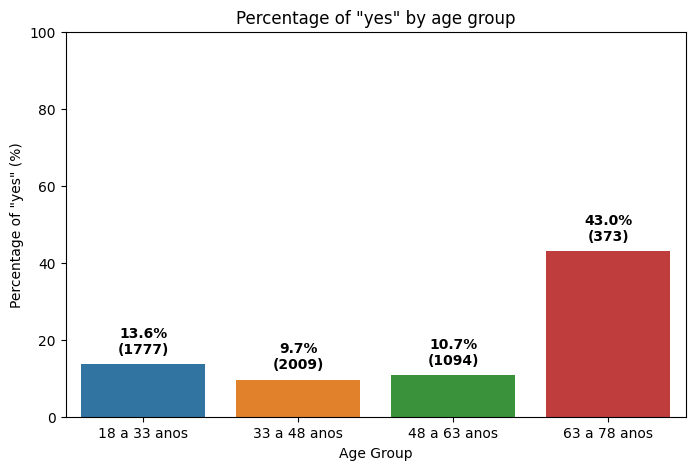

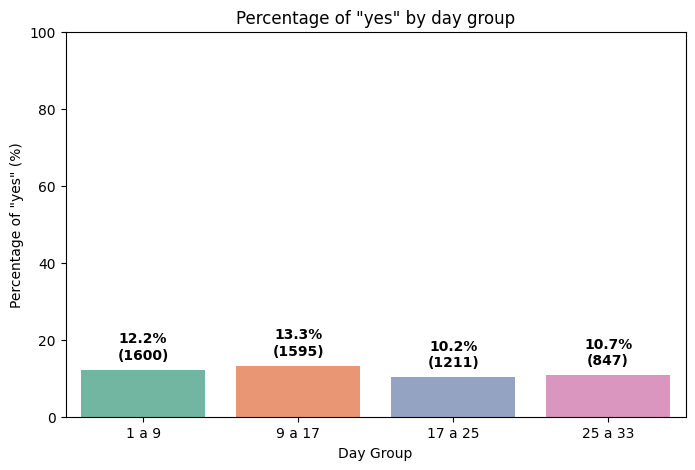

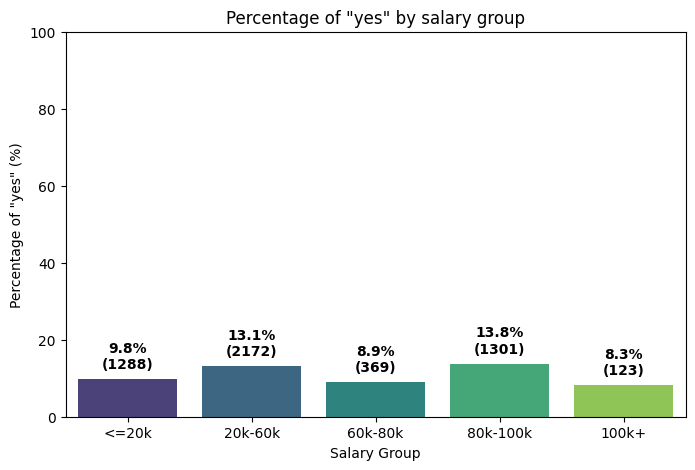

In [309]:

age_grouped = df_faixas_final.groupby('age_faixa')['response'].agg(['mean', 'sum', 'count'])
age_grouped['percent'] = age_grouped['mean'] * 100

plt.figure(figsize=(8,5))
ax = sns.barplot(x=age_grouped.index, y=age_grouped['percent'], palette='tab10')
plt.title('Percentage of "yes" by age group')
plt.ylabel('Percentage of "yes" (%)')
plt.xlabel('Age Group')
plt.ylim(0, 100)

for i, (percent, total_yes) in enumerate(zip(age_grouped['percent'], age_grouped['sum'])):
    ax.text(i, percent + 2, f'{percent:.1f}%\n({int(total_yes)})', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.show()

day_grouped = df_faixas_final.groupby('day_faixa')['response'].agg(['mean', 'sum', 'count'])
day_grouped['percent'] = day_grouped['mean'] * 100

plt.figure(figsize=(8,5))
ax2 = sns.barplot(x=day_grouped.index, y=day_grouped['percent'], palette='Set2')
plt.title('Percentage of "yes" by day group')
plt.ylabel('Percentage of "yes" (%)')
plt.xlabel('Day Group')
plt.ylim(0, 100)

for i, (percent, total_yes) in enumerate(zip(day_grouped['percent'], day_grouped['sum'])):
    ax2.text(i, percent + 2, f'{percent:.1f}%\n({int(total_yes)})', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.show()

salary_grouped = df_faixas_final.groupby('salary_faixa')['response'].agg(['mean', 'sum', 'count'])
salary_grouped['percent'] = salary_grouped['mean'] * 100

plt.figure(figsize=(8,5))
ax3 = sns.barplot(x=salary_grouped.index, y=salary_grouped['percent'], palette='viridis')
plt.title('Percentage of "yes" by salary group')
plt.ylabel('Percentage of "yes" (%)')
plt.xlabel('Salary Group')
plt.ylim(0, 100)

for i, (percent, total_yes) in enumerate(zip(salary_grouped['percent'], salary_grouped['sum'])):
    ax3.text(i, percent + 2, f'{percent:.1f}%\n({int(total_yes)})', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.show()


After binning, we observed that **Day** and **Salary** showed no consistent relationship with the target variable (`response`).  

- **Day:** dividing the days into intervals did not reveal a pattern of higher acceptance during specific periods of the month. The distribution of responses appeared random, with no relevant concentration to justify using this variable for the analysis.  
- **Salary (balance):** even after grouping into value ranges, there was no clear association between balances and offer acceptance. Clients with higher or lower balances showed similar response rates, indicating that this factor is not determinant in the observed behavior.  

In contrast, the **Age** variable showed slightly different behavior. Although most age ranges did not show significant correlation with the response, a **small peak of acceptance among clients over 63 years old** was identified. This could suggest a trend, but the representativeness of this group within the sample is extremely low, limiting its statistical relevance and preventing solid conclusions.  

Thus, we can consider that **Day**, **Salary**, and **Age** are not suitable variables to contribute to the analysis objective, as they do not demonstrate a consistent or significant relationship with the client's final response.


In [310]:
df = df.drop(columns=['age'])
df = df.drop(columns=['day'])
df = df.drop(columns=['salary'])
range_columns = [col for col in df.columns if 'faixa' in col]
df = df.drop(columns=range_columns)


##### Camapign and Loan


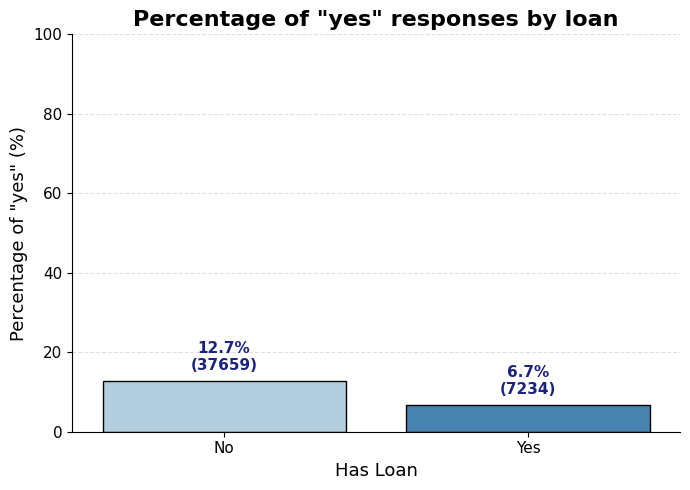

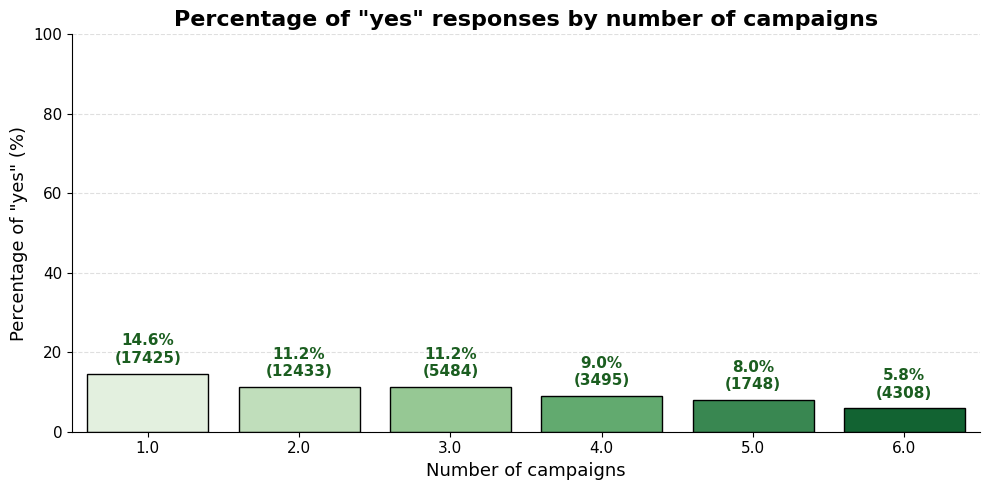

In [311]:
proportion_yes_loan = df.groupby('loan')['response'].mean() * 100
count_loan = df.groupby('loan')['response'].count()

if set(proportion_yes_loan.index) == {0, 1} or set(proportion_yes_loan.index) == {'no', 'yes'}:
    if proportion_yes_loan.index.dtype == 'O':
        x_labels = ['No', 'Yes'] if 'no' in proportion_yes_loan.index else list(proportion_yes_loan.index)
    else:
        x_labels = ['No', 'Yes']
else:
    x_labels = proportion_yes_loan.index.astype(str)

plt.figure(figsize=(7, 5))
ax = sns.barplot(x=x_labels, y=proportion_yes_loan.values, palette='Blues', edgecolor='black')
plt.title('Percentage of "yes" responses by loan', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of "yes" (%)', fontsize=13)
plt.xlabel('Has Loan', fontsize=13)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

for i, (percent, total) in enumerate(zip(proportion_yes_loan.values, count_loan.values)):
    ax.text(i, percent + 2, f'{percent:.1f}%\n({total})', ha='center', va='bottom',
            fontsize=11, fontweight='bold', color='#1a237e')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

proportion_yes_campaign = df.groupby('campaign')['response'].mean() * 100
count_campaign = df.groupby('campaign')['response'].count()

plt.figure(figsize=(10, 5))
if all([(str(x).isdigit() and 1 <= int(x) <= 12) for x in proportion_yes_campaign.index]):
    month_names_campaign = [meses_nomes_pt[int(x)-1] for x in proportion_yes_campaign.index]
    x_labels = month_names_campaign
    xlabel = 'Month (number of campaigns)'
else:
    x_labels = proportion_yes_campaign.index.astype(str)
    xlabel = 'Number of campaigns'

ax2 = sns.barplot(x=x_labels, y=proportion_yes_campaign.values, palette='Greens', edgecolor='black')
plt.title('Percentage of "yes" responses by number of campaigns', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of "yes" (%)', fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
ax2.set_axisbelow(True)
for i, (percent, total) in enumerate(zip(proportion_yes_campaign.values, count_campaign.values)):
    ax2.text(i, percent + 2, f'{percent:.1f}%\n({total})', ha='center', va='bottom', fontsize=11, fontweight='bold', color='#1b5e20')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()


**Loan**  
- **Clients without an existing loan:** had an acceptance rate of **12.7%**.  
- **Clients already in debt:** had an acceptance rate of only **6.7%**.  

This result suggests that prior indebtedness is an important resistance factor: those who already have a financial commitment are less willing to take on a new one. Therefore, the `loan` variable functions as an indicator of **propensity to decline**, theoretically.

**Campaign**  
The number of contacts made during the campaign also showed a **clear pattern of diminishing returns**:  
- The more times a client was contacted, the **lower the probability of accepting the offer**.  
- This suggests phenomena such as:  
  - **Saturation:** excessive contacts in the same campaign cause strain in the relationship;  
  - **Reinforcement of resistance:** each unsuccessful attempt consolidates refusal;  

**Conclusion**  
- **Persistence within the same campaign** tends to **reduce success**.  
- **Previous contact history in earlier campaigns**, on the other hand, is a positive factor, indicating a higher chance of conversion.  

Thus, the results reinforce that the most effective strategy is not to insist repeatedly in a short period, but rather to **value clients who were already contacted previously**, cultivating a trusting relationship over time.


Observing that the acceptance rate tends to decrease as the `campaign` variable increases, we will statistically assess this trend using the Cochran-Armitage trend test.

The Cochran-Armitage test is used when we have two variables:

1. A **binary** variable indicating success or failure (e.g., accepted the offer: yes or no).  
2. An **ordinal** variable indicating an order among the groups (e.g., number of contacts: 1, 2, 3...).

The purpose of the test is to determine whether there is a **linear trend** in the proportion of successes as the ordinal variable increases.

**Basic steps of the test:**

1. **Organize the data**: create a contingency table, with rows representing the ordered groups and columns representing success/failure.  
2. **Assign weights**: each ordinal group receives a weight (usually consecutive numbers, like 1, 2, 3...).  
3. **Calculate the test statistic**:  
   The statistic measures how much the proportion of successes follows the expected linear trend based on the weights. Mathematically, it is a type of **correlation between the weights and the success proportions**.  
4. **Compare with the reference distribution**:  
   The test statistic approximately follows a **chi-square** distribution with 1 degree of freedom. Using this, we can calculate the **p-value** and determine if the trend is statistically significant.

In summary, the test not only compares groups but also **quantifies whether there is a consistent trend of increasing or decreasing success** across ordered groups.

In [312]:

valid_data = df.loc[df['campaign'].notnull() & df['response'].notnull()]

contingency = pd.crosstab(valid_data['campaign'], valid_data['response'])

if 1 not in contingency.columns:
    contingency[1] = 0
contingency = contingency.sort_index()

successes = contingency[1].values
total = contingency.sum(axis=1).values
scores = contingency.index.values

mean_score = np.average(scores, weights=total)
p_total = successes.sum() / total.sum()

numerator = np.sum((scores - mean_score) * successes)
denominator = np.sqrt(p_total * (1 - p_total) * np.sum(total * (scores - mean_score) ** 2))

if denominator != 0:
    z_cochran = numerator / denominator
    from scipy.stats import norm
    p_cochran = 2 * (1 - norm.cdf(abs(z_cochran)))
    print(f"Cochran-Armitage trend statistic (Z): {z_cochran:.4f}")
    print(f"Cochran-Armitage test p-value: {p_cochran:.4g}")
    if p_cochran < 0.05:
        print("There is evidence of a significant monotonic trend between campaign and response (p < 0.05).")
    else:
        print("There is no evidence of a significant monotonic trend between campaign and response (p >= 0.05).")
else:
    print("It was not possible to calculate the Cochran-Armitage test (zero denominator).")

Cochran-Armitage trend statistic (Z): -17.6790
Cochran-Armitage test p-value: 0
There is evidence of a significant monotonic trend between campaign and response (p < 0.05).


- Trend statistic (Z): **-17.6790**  
- Test p-value: **0**  

The result indicates that there is a **significant monotonic trend** between `campaign` and `response` (p < 0.05).  

We can conclude that there is a **negative trend**, meaning that as the number of campaigns increases, the acceptance rate tends to **decrease**, confirming the initial hypothesis.


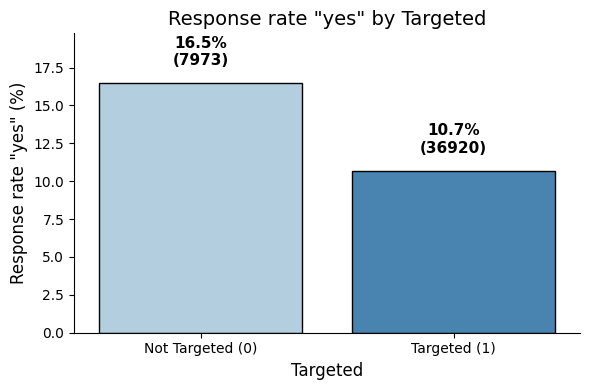

In [313]:

response_rate_by_targeted = df.groupby('targeted')['response'].mean() * 100
count_by_targeted = df['targeted'].value_counts().sort_index()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=response_rate_by_targeted.index, y=response_rate_by_targeted.values, palette='Blues', edgecolor='black')
for i, (percent, total) in enumerate(zip(response_rate_by_targeted.values, count_by_targeted.values)):
    ax.text(i, percent + 1, f'{percent:.1f}%\n({total})', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticklabels(['Not Targeted (0)', 'Targeted (1)'])
ax.set_ylabel('Response rate "yes" (%)', fontsize=12)
ax.set_xlabel('Targeted', fontsize=12)
ax.set_title('Response rate "yes" by Targeted', fontsize=14)
plt.ylim(0, max(response_rate_by_targeted.values)*1.2)
sns.despine()
plt.tight_layout()
plt.show()


- Clients **not targeted** (`Targeted = 0`) had a "yes" response rate of **16.5%**.  
- Clients **targeted** (`Targeted = 1`) had a "yes" response rate of **10.7%**.  

Although the difference seems large, **we should not interpret it as a strong relationship** with the response variable.  
The statistical analysis indicates that the `Targeted` variable **does not have a significant association** with the response.


We could consider removing the variable, but since the Spearman coefficient **is not fully reliable for binary variables**, we will choose to analyze it together with the categorical variables.  

This analysis will be performed using **Weight of Evidence (WoE)** and **Information Value (IV)** metrics, which help better measure the explanatory power of each variable in relation to the response.


### WoE and IV Correlation

#### Weight of Evidence (WoE) and Information Value (IV)

The **WoE** and **IV** metrics are widely used in risk analysis and predictive modeling to measure the **strength of the relationship between an independent variable and the response variable** (usually binary, such as "yes" or "no").

**Weight of Evidence (WoE)**

The **WoE** transforms categories or intervals of a variable into continuous values that reflect the **proportion of good and bad outcomes** in each group.

For each group \(i\) of the variable:

\[
WoE_i = \ln \left( \frac{\text{Distribution of goods in group } i}{\text{Distribution of bads in group } i} \right)
\]

- **Goods**: cases where the response is "no" (or the non-event of interest).  
- **Bads**: cases where the response is "yes" (or the event of interest).  
- The logarithm helps **linearize the relationship**, facilitating use in models such as logistic regression.

**Information Value (IV)**

The **IV** quantifies the **overall explanatory power** of a variable. It is the weighted sum of WoE across all groups:

\[
IV = \sum_i (\text{Proportion of goods}_i - \text{Proportion of bads}_i) \times WoE_i
\]

Approximate interpretation of IV:

- IV < 0.02 → No predictive power  
- 0.02 ≤ IV < 0.1 → Weak predictive power  
- 0.1 ≤ IV < 0.3 → Medium predictive power  
- 0.3 ≤ IV < 0.5 → Strong predictive power  
- IV ≥ 0.5 → Very strong variable or possibly overfitted

In summary, **WoE transforms the variable into values that show the strength of each group regarding the event**, while **IV measures the overall importance of the variable**.

In [314]:
def calculate_woe_iv(df, feature, target):
    """
    Calculates WOE and IV for a categorical or binary variable in relation to a binary target.
    Returns a DataFrame with WOE and IV values per category and the total IV.
    """
    eps = 1e-10
    df_temp = df[[feature, target]].copy()
    total_event = (df_temp[target] == 1).sum()
    total_non_event = (df_temp[target] == 0).sum()
    grouped = df_temp.groupby(feature)[target].agg(['count', 'sum'])
    grouped = grouped.rename(columns={'count': 'total', 'sum': 'event'})
    grouped['non_event'] = grouped['total'] - grouped['event']
    grouped['perc_event'] = grouped['event'] / (total_event + eps)
    grouped['perc_non_event'] = grouped['non_event'] / (total_non_event + eps)
    grouped['woe'] = np.log((grouped['perc_event'] + eps) / (grouped['perc_non_event'] + eps))
    grouped['iv'] = (grouped['perc_event'] - grouped['perc_non_event']) * grouped['woe']
    iv_total = grouped['iv'].sum()
    return grouped[['woe', 'iv']], iv_total

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
if 'response' in categorical_columns:
    categorical_columns.remove('response')

if 'age_group' in df.columns and 'age_group' not in categorical_columns:
    categorical_columns.append('age_group')

binary_columns = []
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'response' and df[col].nunique() == 2:
        binary_columns.append(col)

woe_iv_columns = categorical_columns + binary_columns

print("WOE and IV analysis for categorical and binary variables in relation to the response variable:\n")
for col in woe_iv_columns:
    print(f"Variable: {col}")
    woe_iv_df, iv_total = calculate_woe_iv(df, col, 'response')
    print(woe_iv_df)
    print(f"Total IV for {col}: {iv_total:.4f}\n")
    if iv_total < 0.02:
        interpretation = "No predictive power"
    elif iv_total < 0.1:
        interpretation = "Weak predictive power"
    elif iv_total < 0.3:
        interpretation = "Medium predictive power"
    elif iv_total < 0.5:
        interpretation = "Strong predictive power"
    else:
        interpretation = "Suspicious predictive power or variable may be overfitted"
    print(f"IV interpretation: {interpretation}\n{'-'*50}\n")


WOE and IV analysis for categorical and binary variables in relation to the response variable:

Variable: marital
               woe        iv
marital                     
divorced  0.025978  0.000079
married  -0.162348  0.014889
single    0.281433  0.024957
Total IV for marital: 0.0399

IV interpretation: Weak predictive power
--------------------------------------------------

Variable: job
                    woe        iv
job                              
admin.         0.046958  0.000258
blue-collar   -0.523605  0.048561
entrepreneur  -0.384220  0.004215
housemaid     -0.317586  0.002463
management     0.185787  0.007802
retired        0.801491  0.043407
self-employed  0.010447  0.000004
services      -0.305908  0.007690
student        1.109967  0.038107
technician    -0.063153  0.000658
unemployed     0.325333  0.003474
Total IV for job: 0.1566

IV interpretation: Medium predictive power
--------------------------------------------------

Variable: edu
                woe        

Before analyzing the categorical variables, let's evaluate the binary variables based on their predictive power and balance.

- **Targeted**  
  The variable shows **weak predictive power** and is highly unbalanced. Since it does not reach at least medium predictive power, it will be **removed**.

- **Loan**  
  Although it shows some trend (higher "yes" response for clients without loans), the variable is **unbalanced** and has **low statistical value**. Therefore, it will be **removed**.

- **Housing**  
  Shows **medium predictive power** (WoE/IV) and good Spearman correlation, in addition to being balanced. Therefore, it will be **kept**.

- **Was_p_contacted**  
  Although highly unbalanced, it has **medium predictive power** in WoE/IV and **high Spearman correlation**. It will be **kept**.

- **Contacted_cellphone**  
  Is **balanced** and shows **medium predictive power**. It will be **kept**.


In [315]:
df = df.drop(columns=['targeted', 'loan'])


##### Contact_cellphone

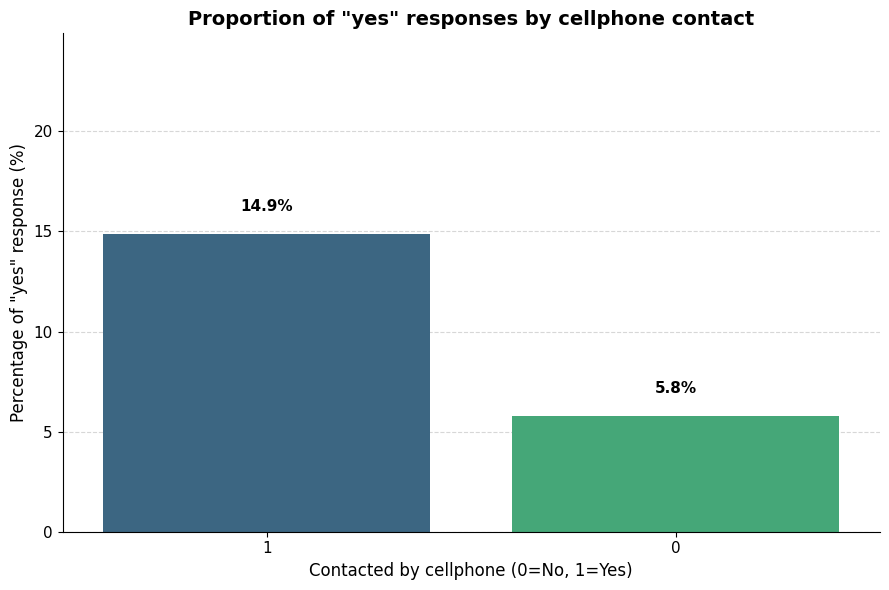

In [316]:

proportion_yes_contacted = df.groupby('contacted_cellphone')['response'].mean().reset_index()
proportion_yes_contacted['response'] = proportion_yes_contacted['response'] * 100

order_contacted = proportion_yes_contacted.sort_values('response', ascending=False)['contacted_cellphone']

plt.figure(figsize=(9,6))
ax = sns.barplot(
    data=proportion_yes_contacted, 
    x='contacted_cellphone', 
    y='response', 
    palette='viridis', 
    order=order_contacted
)

ax.set_ylabel('Percentage of "yes" response (%)', fontsize=12)
ax.set_xlabel('Contacted by cellphone (0=No, 1=Yes)', fontsize=12)
ax.set_title('Proportion of "yes" responses by cellphone contact', fontsize=14, fontweight='bold')
ax.set_ylim(0, proportion_yes_contacted['response'].max() + 10)

for i, row in proportion_yes_contacted.set_index('contacted_cellphone').loc[order_contacted].reset_index().iterrows():
    ax.text(i, row['response'] + 1, f"{row['response']:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


- **Information Value (IV):** 0.2099 → **Relevant**  

| Category       | WoE       | Response Proportion | Interpretation                        |
|----------------|-----------|------------------|--------------------------------------|
| Cellphone      | -0.767576 | 0.154025          | Higher chance of negative response   |
| No Cellphone   | 0.278231  | 0.055831          | Higher chance of positive response   |

As observed, **contact via cellphone proves to be the most effective strategy** for generating positive responses.


##### Job

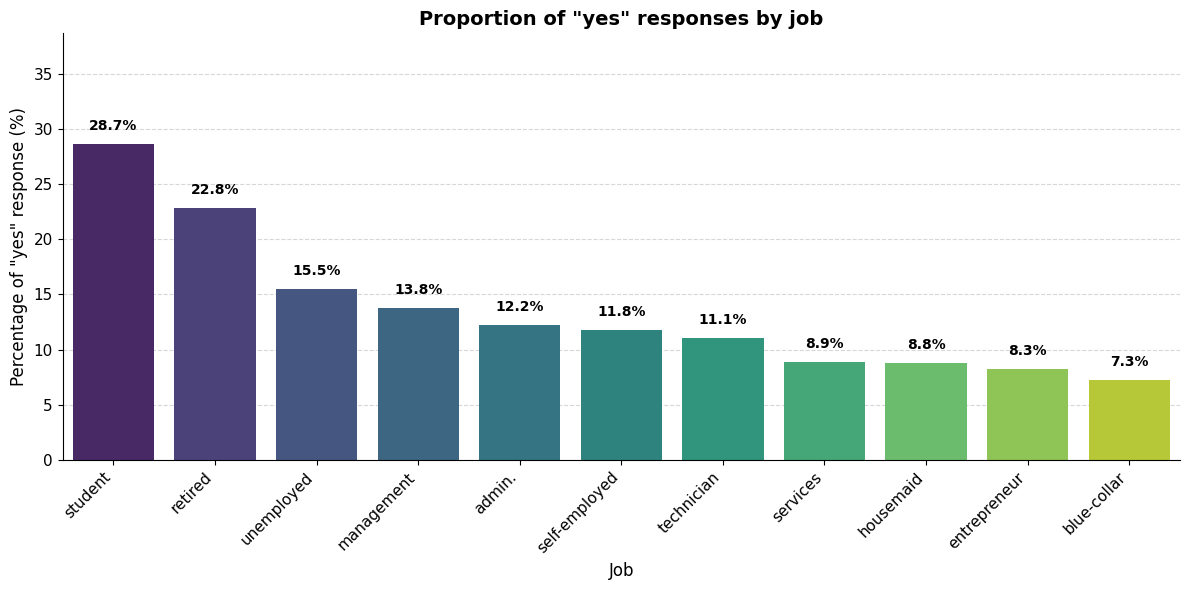

In [317]:
proportion_yes_job = df.groupby('job')['response'].mean().reset_index()
proportion_yes_job['response'] = proportion_yes_job['response'] * 100

order_job = proportion_yes_job.sort_values('response', ascending=False)['job']

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=proportion_yes_job, 
    x='job', 
    y='response', 
    palette='viridis', 
    order=order_job
)

ax.set_ylabel('Percentage of "yes" response (%)', fontsize=12)
ax.set_xlabel('Job', fontsize=12)
ax.set_title('Proportion of "yes" responses by job', fontsize=14, fontweight='bold')
ax.set_ylim(0, proportion_yes_job['response'].max() + 10)

for i, row in proportion_yes_job.set_index('job').loc[order_job].reset_index().iterrows():
    ax.text(i, row['response'] + 1, f"{row['response']:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


- **Information Value (IV):** 0.1566 → **Moderately relevant**  

| Category      | WoE     | Interpretation                       |
|---------------|---------|--------------------------------------|
| student       | 1.110   | Highly likely to accept             |
| retired       | 0.801   | Strong tendency to accept           |
| blue-collar   | -0.524  | Strong tendency to decline          |
| housemaid     | -0.318  | More likely to refuse               |
| management    | 0.186   | Slight positive tendency            |

- Students and retirees show a **strong inclination for a positive response**.  
- Operational profiles (blue-collar and housemaid) have a **higher tendency to decline**.  

The `job` variable shows **good statistical value** and clear differences in "yes" responses across categories.


##### Marital

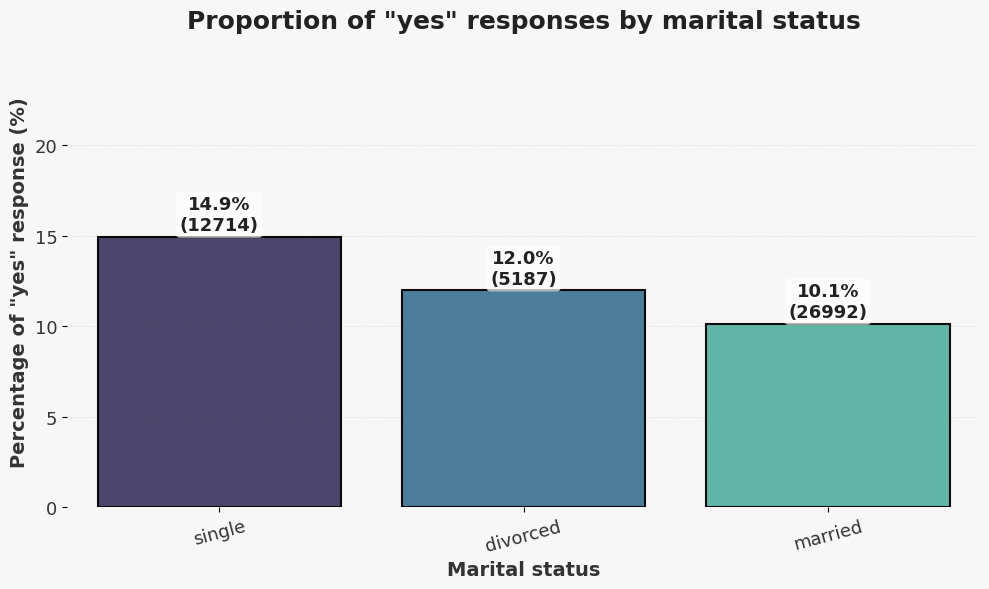

In [318]:
proportion_yes_marital = df.groupby('marital')['response'].mean() * 100
marital_count = df['marital'].value_counts().reset_index()
marital_count.columns = ['marital', 'count']
proportion_yes_marital = proportion_yes_marital.reset_index().sort_values(by='response', ascending=False)
proportion_yes_marital = proportion_yes_marital.merge(marital_count, on='marital', how='left')

colors = sns.color_palette("mako", len(proportion_yes_marital))

fig, ax = plt.subplots(figsize=(10, 6), facecolor='#f7f7f7')
bars = sns.barplot(
    data=proportion_yes_marital,
    x='marital',
    y='response',
    palette=colors,
    ax=ax
)

for i, bar in enumerate(ax.patches):
    bar.set_edgecolor('black')
    bar.set_linewidth(1.5)
    bar.set_alpha(0.95)

ax.set_ylabel('Percentage of "yes" response (%)', fontsize=14, fontweight='bold', color='#333333')
ax.set_xlabel('Marital status', fontsize=14, fontweight='bold', color='#333333')
ax.set_title('Proportion of "yes" responses by marital status', fontsize=18, fontweight='bold', color='#222222', pad=20)
ax.set_ylim(0, proportion_yes_marital['response'].max() + 10)

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    n_values = proportion_yes_marital.iloc[i]['count']
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + (proportion_yes_marital['response'].max() * 0.01),
        f"{height:.1f}%\n({n_values})", 
        ha='center', va='bottom', fontsize=13, fontweight='bold', color='#222222',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

sns.despine(left=True, bottom=True)
ax.grid(axis='y', linestyle=':', alpha=0.35, zorder=0)
ax.set_axisbelow(True)
plt.xticks(rotation=15, fontsize=13, color='#333333')
plt.yticks(fontsize=13, color='#333333')
ax.set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


- **Information Value (IV):** 0.0399 → **Weak**  

| Category  | WoE     | Interpretation                     |
|-----------|---------|------------------------------------|
| single    | 0.281   | More likely to accept             |
| married   | -0.162  | Slight tendency to decline        |
| divorced  | 0.026   | Neutral / slight positive tendency|

- Single individuals show **higher receptivity** to the offer, but the difference is not strong enough.  
- The low statistical value indicates **weak predictive power**.

Therefore, although `marital` may add some value when combined with other variables, **it is not useful alone** and will be **removed**.


In [319]:
df = df.drop(columns=['marital'])


##### Edu

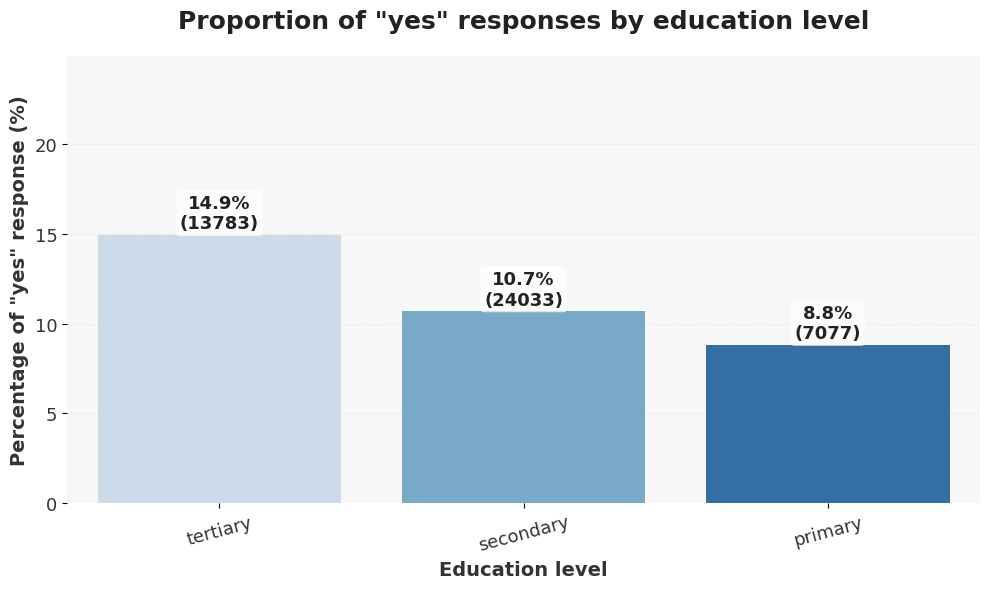

In [320]:
proportion_yes_edu = df.groupby('edu')['response'].agg(['mean', 'count'])
proportion_yes_edu['response'] = proportion_yes_edu['mean'] * 100
proportion_yes_edu = proportion_yes_edu.reset_index()
proportion_yes_edu = proportion_yes_edu.sort_values(by='response', ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=proportion_yes_edu, x='edu', y='response', palette='Blues')

ax.set_ylabel('Percentage of "yes" response (%)', fontsize=14, fontweight='bold', color='#333333')
ax.set_xlabel('Education level', fontsize=14, fontweight='bold', color='#333333')
ax.set_title('Proportion of "yes" responses by education level', fontsize=18, fontweight='bold', color='#222222', pad=20)
ax.set_ylim(0, proportion_yes_edu['response'].max() + 10)

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    n_values = proportion_yes_edu.iloc[i]['count']
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + (proportion_yes_edu['response'].max() * 0.01), 
        f"{height:.1f}%\n({n_values})", 
        ha='center', va='bottom', fontsize=13, fontweight='bold', color='#222222',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

sns.despine(left=True, bottom=True)
ax.grid(axis='y', linestyle=':', alpha=0.35, zorder=0)
ax.set_axisbelow(True)
plt.xticks(rotation=15, fontsize=13, color='#333333')
plt.yticks(fontsize=13, color='#333333')
ax.set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


- **Information Value (IV):** 0.0463 → **Weak**  

| Category  | WoE     | Interpretation                   |
|-----------|---------|----------------------------------|
| tertiary  | 0.282   | More likely to accept           |
| primary   | -0.315  | Less likely                     |
| secondary | -0.101  | Slight tendency to decline      |

- It is observed that **higher education levels tend to be associated with accepting the offer**.  
- Despite the weak predictive power, the variable shows **some relation to the target variable**.

We can consider it as an **ordinal variable** and apply the **Cochran-Armitage trend test** to further investigate this relationship.


In [321]:
edu_mapping = {'primary': 1, 'secondary': 2, 'tertiary': 3}
df['edu_num'] = df['edu'].map(edu_mapping)

valid_data = df.loc[df['edu_num'].notnull() & df['response'].notnull()]

contingency = pd.crosstab(valid_data['edu_num'], valid_data['response'])

successes = contingency[1].values
total = contingency.sum(axis=1).values
scores = contingency.index.values

mean_score = np.average(scores, weights=total)
p_total = successes.sum() / total.sum()

numerator = np.sum((scores - mean_score) * successes)
denominator = np.sqrt(p_total * (1 - p_total) * np.sum(total * (scores - mean_score) ** 2))

if denominator != 0:
    z_cochran = numerator / denominator
    from scipy.stats import norm
    p_cochran = 2 * (1 - norm.cdf(abs(z_cochran)))
    print(f"Cochran-Armitage trend statistic (Z): {z_cochran:.4f}")
    print(f"Cochran-Armitage test p-value: {p_cochran:.4g}")
    if p_cochran < 0.05:
        print("There is evidence of a significant monotonic trend between education and response (p < 0.05).")
    else:
        print("There is no evidence of a significant monotonic trend between education and response (p >= 0.05).")
else:
    print("It was not possible to calculate the Cochran-Armitage test (denominator zero).")


Cochran-Armitage trend statistic (Z): 14.3570
Cochran-Armitage test p-value: 0
There is evidence of a significant monotonic trend between education and response (p < 0.05).


- **Z Statistic:** 14.3570 → Very high value, indicating **strong evidence of a monotonic trend** in the proportion of "yes" responses as education level increases.  
- **p-value:** 0 (or near zero) → The trend is **highly statistically significant**.  

The test confirms that there is a **consistent and real relationship** between education and the binary response.  
Therefore, the variable `edu_num` will be **kept**.


In [322]:
if 'edu' in df.columns:
    df = df.drop(columns=['edu'])


##### Semester

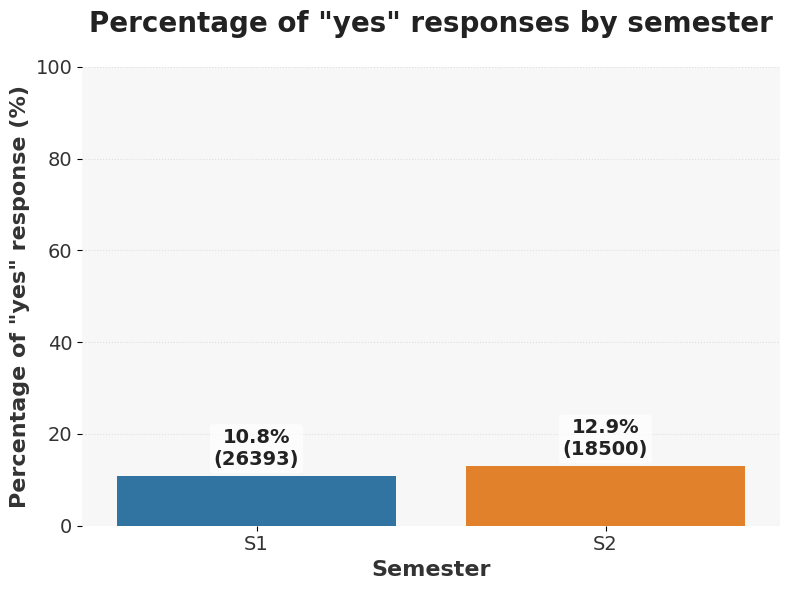

In [323]:
proportion_by_semester = df.groupby('semester_2017')['response'].agg(['mean', 'count'])
proportion_by_semester['percent'] = proportion_by_semester['mean'] * 100

semester_order = sorted(df['semester_2017'].unique())
proportion_by_semester = proportion_by_semester.loc[semester_order]

fig, ax = plt.subplots(figsize=(8,6))

colors = ['#1f77b4', '#ff7f0e'][:len(proportion_by_semester)]

bars = sns.barplot(
    x=proportion_by_semester.index,
    y=proportion_by_semester['percent'],
    palette=colors,
    ax=ax
)

ax.set_ylabel('Percentage of "yes" response (%)', fontsize=16, fontweight='bold', color='#333333')
ax.set_xlabel('Semester', fontsize=16, fontweight='bold', color='#333333')
ax.set_title('Percentage of "yes" responses by semester', fontsize=20, fontweight='bold', color='#222222', pad=25)
ax.set_ylim(0, 100)
ax.set_facecolor('#f7f7f7')
sns.despine(left=True, bottom=True)
ax.grid(axis='y', linestyle=':', alpha=0.35, zorder=0)
ax.set_axisbelow(True)
plt.yticks(fontsize=14, color='#333333')

for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    total = int(proportion_by_semester['count'].iloc[i])
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.5,
        f"{height:.1f}%\n({total})",
        ha='center', va='bottom', fontsize=14, fontweight='bold', color='#222222',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

ax.set_xticklabels(proportion_by_semester.index, rotation=0, fontsize=14, color='#333333')

plt.tight_layout()
plt.show()

| Category      | WoE        | Interpretation                   |
|---------------|------------|---------------------------------|
| 1st Semester  | -0.087327  | Slight tendency to reject       |
| 2nd Semester  | 0.115293   | Slight tendency to accept       |

- **Total Information Value (IV):** 0.0101 → **No predictive power**  

The values indicate that **neither semester shows a significant relationship** with the target variable.  
Therefore, the variable `semester` will be **removed**.


In [324]:
df = df.drop(columns=['semester_2017'])


## 6. Multivariate Analysis

In [325]:
df.head()

,balance,housing,duration,campaign,previous,response,job,contacted_cellphone,was_p_contacted,salary_bin,day_bin,age_bin,edu_num
0,2143.0,1,261.0,1.0,0,0,management,0,0,80k-100k,1 to 9,48 to 63 years,3
1,29.0,1,151.0,1.0,0,0,technician,0,0,20k-60k,1 to 9,33 to 48 years,2
2,2.0,1,76.0,1.0,0,0,entrepreneur,0,0,100k+,1 to 9,18 to 33 years,2
3,1506.0,1,92.0,1.0,0,0,blue-collar,0,0,<=20k,1 to 9,33 to 48 years,1
5,231.0,1,139.0,1.0,0,0,management,0,0,80k-100k,1 to 9,33 to 48 years,3


After analyzing and removing variables with low predictive power, we reduced the dataset from **17 variables to 10**.

Before proceeding with **multivariate analysis**, it is important to check for **collinearity** among the remaining variables.  
High collinearity can distort results, inflate standard errors, and make it difficult to interpret the effect of each variable individually.

#### Collinearity Check

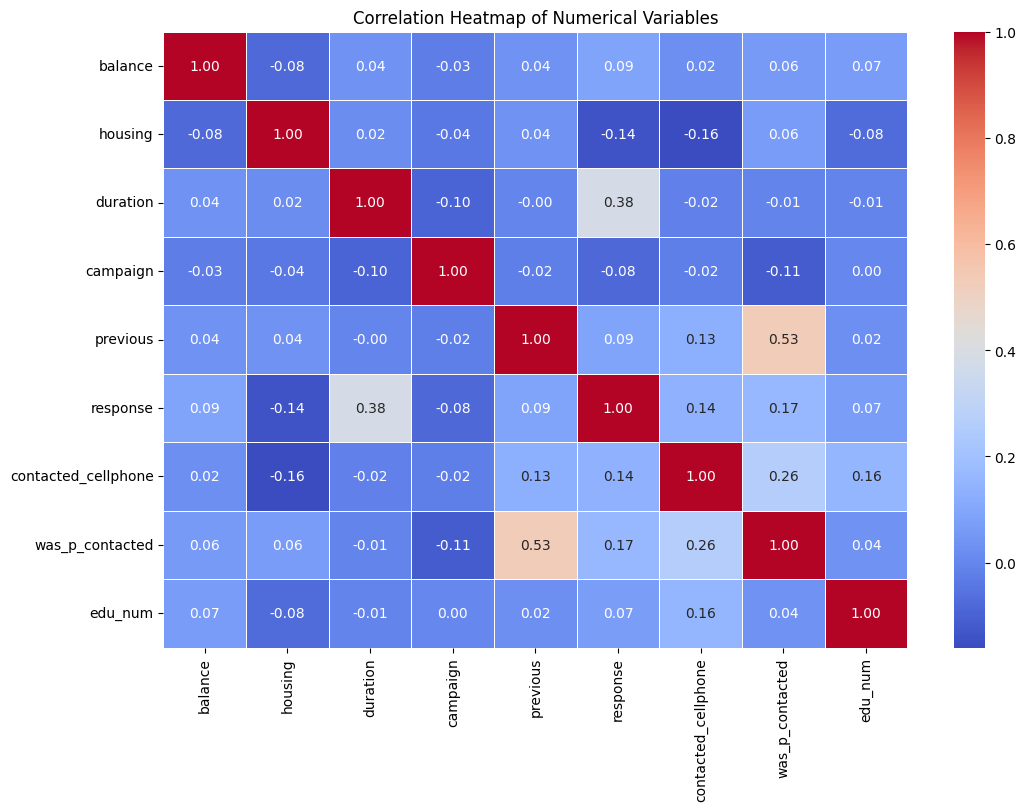

In [326]:

corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


- The highest correlation among explanatory variables is **previous × was_p_contacted = 0.53**.  
  - This is a **moderate correlation**, still **below the critical threshold** for serious collinearity (usually > 0.8).  
  - We could consider removing one if both provide the same information. However:  
    - `was_p_contacted` indicates that **acceptance is higher when the client was contacted previously**.  
    - `previous` shows that **acceptance increases with the number of prior contacts**, up to about 10 contacts.

- The other correlations are very close to **zero**, indicating that the remaining variables **provide largely independent information**.

#### Purpose of Multivariate Analysis

The goal of multivariate analysis is to:

- Discover **interactions and patterns** that do not appear when analyzing each variable individually.  
- Understand if the **combination of factors** (e.g., age and balance) creates profiles more likely to accept the offer.  
- Provide **insights for segmentation, business decisions, or model building**.

Before combining all variables, we should **consider the types of variables and the objectives of the analysis**.

#### First Study: Call Duration × Account Balance

- Question we want to answer:  
  **Do clients with higher balances also tend to stay longer on the call?**


First, let's create a **plot** to check if there is any **visible relationship** between call duration and client balance.


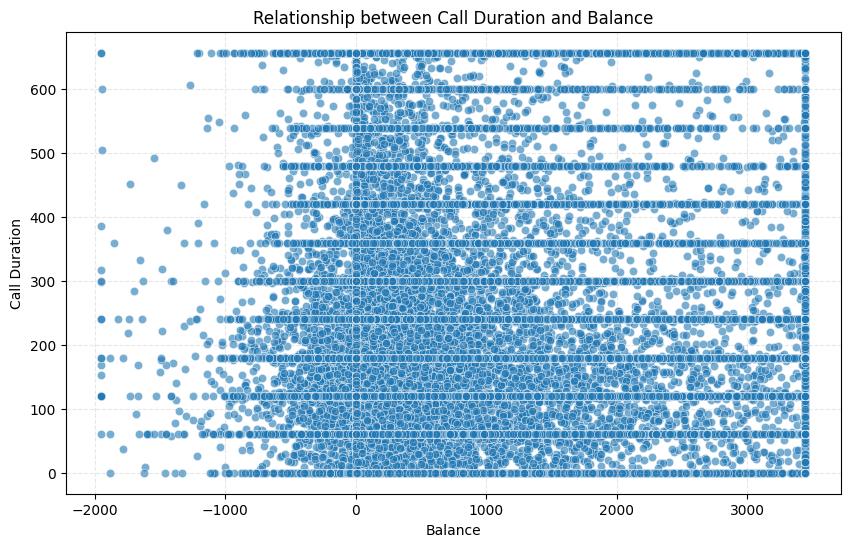

In [327]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='balance', y='duration', alpha=0.6)
plt.title('Relationship between Call Duration and Balance')
plt.xlabel('Balance')
plt.ylabel('Call Duration')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


The plot shows a **scattered cloud**, with no clear linear or curved pattern.  
This suggests that **balance and call duration are not directly related**, partially answering our question.  

Even so, let's analyze whether the **combination of these two variables** has any correlation with the `response` variable.


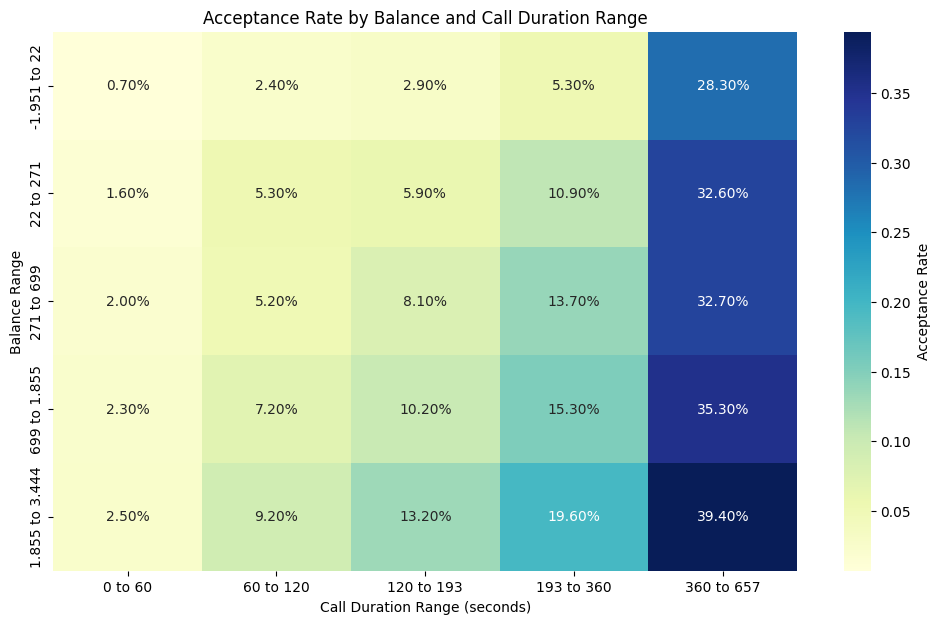

In [328]:
balance_bins = pd.qcut(df['balance'], q=5, duplicates='drop')
balance_bins = balance_bins.apply(lambda x: f"{int(x.left):,} to {int(x.right):,}".replace(",", "."))
df['balance_bin'] = balance_bins

duration_bins = pd.qcut(df['duration'], q=5, duplicates='drop')
duration_bins = duration_bins.apply(lambda x: f"{int(x.left)} to {int(x.right)}")
df['duration_bin'] = duration_bins

acceptance_table = pd.crosstab(
    df['balance_bin'], 
    df['duration_bin'], 
    values=df['response'], 
    aggfunc='mean'
).round(3)

acceptance_table.index.name = 'Balance Range'
acceptance_table.columns.name = 'Duration Range'

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.heatmap(acceptance_table, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Acceptance Rate'})
plt.title('Acceptance Rate by Balance and Call Duration Range')
plt.xlabel('Call Duration Range (seconds)')
plt.ylabel('Balance Range')
plt.show()

- It can be observed that the acceptance rate is **high (39%)** for clients with **call duration above 360 seconds** and **balance between 1,855 and 3,444**.  
- However, before drawing conclusions, let's **analyze the `duration` variable individually**.


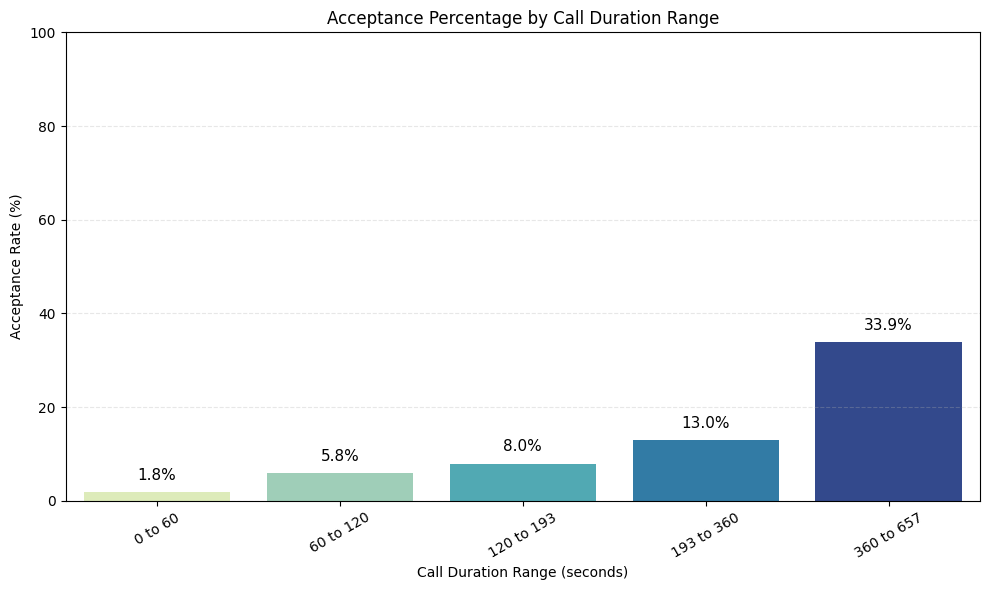

In [329]:
acceptance_rate_duration = df.groupby('duration_bin')['response'].mean() * 100

plt.figure(figsize=(10,6))
bars = sns.barplot(x=acceptance_rate_duration.index, y=acceptance_rate_duration.values, palette='YlGnBu')
plt.ylabel('Acceptance Rate (%)')
plt.xlabel('Call Duration Range (seconds)')
plt.title('Acceptance Percentage by Call Duration Range')
plt.xticks(rotation=30)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

for i, value in enumerate(acceptance_rate_duration.values):
    plt.text(i, value + 2, f"{value:.1f}%", ha='center', va='bottom', fontsize=11, color='black')

plt.show()

if 'duration_bin' in df.columns:
    df.drop(columns=['duration_bin'], inplace=True)



- The **acceptance rate** increases by approximately **5%** as call duration increases.  
- This increment **is not significant enough** to indicate a relevant effect on its own.

#### Second Study: Call Duration × Previous Contact

- Question we want to answer:  

    **Is it worth spending more time on calls with clients who have been contacted before?**

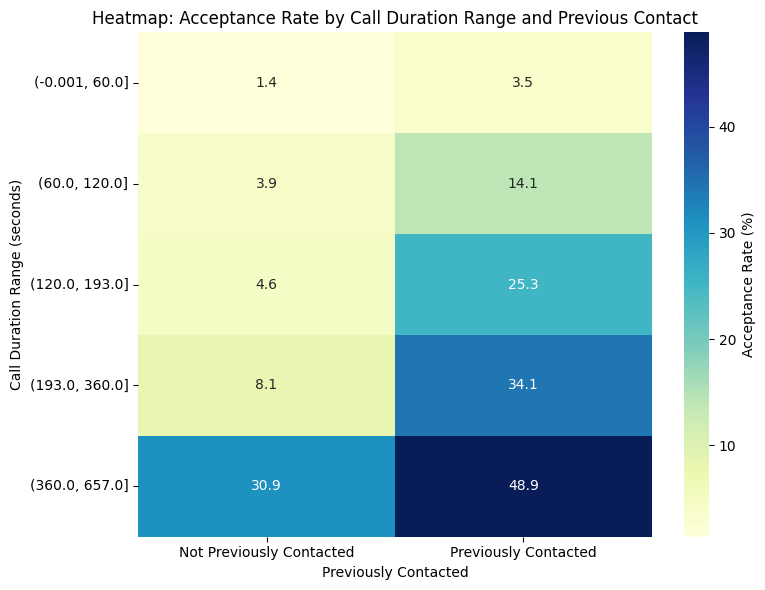

In [330]:
if 'duration_bin' not in df.columns:
    bins_duration = pd.qcut(df['duration'], 5, duplicates='drop')
    df['duration_bin'] = bins_duration

duration_contacted_table = pd.crosstab(
    df['duration_bin'],
    df['was_p_contacted'],
    values=df['response'],
    aggfunc='mean'
).fillna(0)

if 1 in duration_contacted_table.columns:
    duration_contacted_table.columns = ['Not Previously Contacted', 'Previously Contacted']
else:
    duration_contacted_table.columns = ['Not Previously Contacted']

duration_contacted_table_perc = duration_contacted_table * 100

plt.figure(figsize=(8, 6))
sns.heatmap(
    duration_contacted_table_perc,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Acceptance Rate (%)'}
)
plt.title('Heatmap: Acceptance Rate by Call Duration Range and Previous Contact')
plt.xlabel('Previously Contacted')
plt.ylabel('Call Duration Range (seconds)')
plt.tight_layout()
plt.show()

columns_to_remove = []
if 'duration_bin' in df.columns:
    columns_to_remove.append('duration_bin')
if 'balance_bin' in df.columns:
    columns_to_remove.append('balance_bin')
if columns_to_remove:
    df.drop(columns=columns_to_remove, inplace=True)


- For clients **contacted in previous campaigns**, the acceptance rate **increases by more than 18%** when call duration goes from 360 to 657 seconds.  
- This indicates that, **for clients already contacted**, it is advantageous to **spend more time on the call** to increase the likelihood of acceptance.


- This example demonstrates how to conduct **multivariate analysis** of the variables.  
- The same procedure will be applied to all **relevant variables**, and in the final project, only those that prove to be **truly meaningful** will be retained.

In [331]:
df.head()

,balance,housing,duration,campaign,previous,response,job,contacted_cellphone,was_p_contacted,salary_bin,day_bin,age_bin,edu_num
0,2143.0,1,261.0,1.0,0,0,management,0,0,80k-100k,1 to 9,48 to 63 years,3
1,29.0,1,151.0,1.0,0,0,technician,0,0,20k-60k,1 to 9,33 to 48 years,2
2,2.0,1,76.0,1.0,0,0,entrepreneur,0,0,100k+,1 to 9,18 to 33 years,2
3,1506.0,1,92.0,1.0,0,0,blue-collar,0,0,<=20k,1 to 9,33 to 48 years,1
5,231.0,1,139.0,1.0,0,0,management,0,0,80k-100k,1 to 9,33 to 48 years,3


#### Third Study: Call Duration × Previous Contacts

- Question we want to answer:  
  **To what extent can call duration persuade a saturated client to accept?**


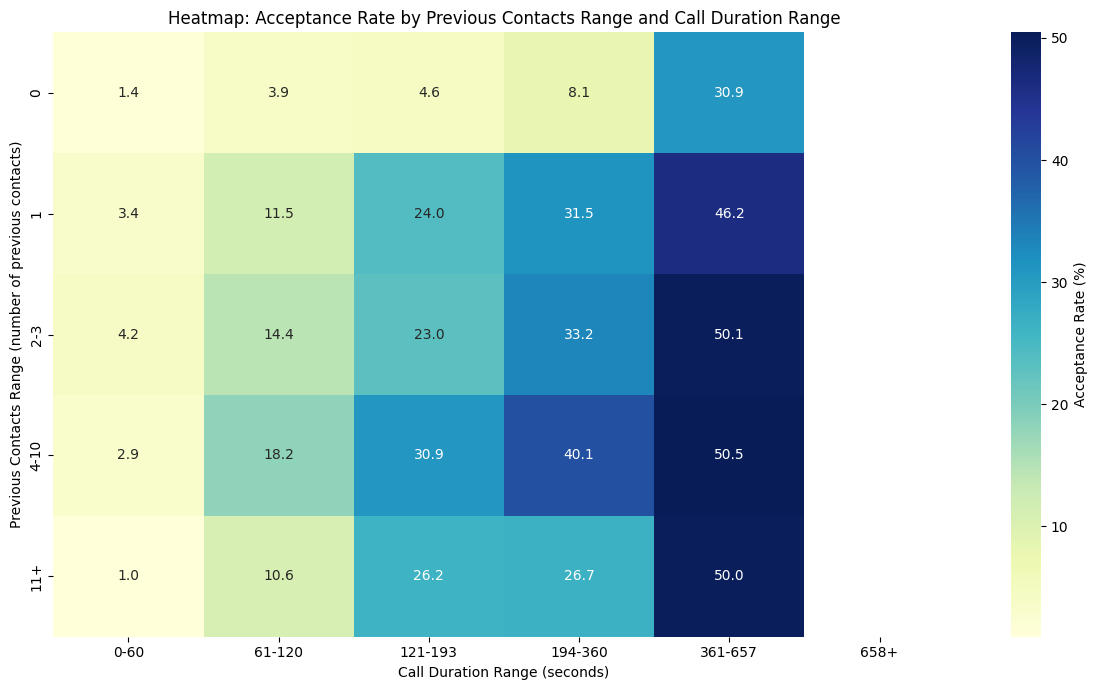

In [332]:
bins_previous = [-1, 0, 1, 3, 10, df['previous'].max()]
bins_previous = sorted(list(set(bins_previous)))
labels_previous = ['0', '1', '2-3', '4-10', '11+'][:len(bins_previous)-1]
df['previous_range'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

max_duration = df['duration'].max()
bins_duration = [0, 60, 120, 193, 360, 657]
if max_duration > 657:
    bins_duration.append(max_duration)
else:
    bins_duration.append(658)
bins_duration = sorted(list(set(bins_duration)))
labels_duration = ['0-60', '61-120', '121-193', '194-360', '361-657', '658+'][:len(bins_duration)-1]
df['duration_range'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

cross_tab = df.groupby(['previous_range', 'duration_range'])['response'].mean().unstack() * 100

plt.figure(figsize=(12, 7))
sns.heatmap(
    cross_tab,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Acceptance Rate (%)'}
)
plt.title('Heatmap: Acceptance Rate by Previous Contacts Range and Call Duration Range')
plt.xlabel('Call Duration Range (seconds)')
plt.ylabel('Previous Contacts Range (number of previous contacts)')
plt.tight_layout()
plt.show()

df = df.drop(columns=['previous_range', 'duration_range'])


1. Stronger Effect at Short/Intermediate Durations
- For **calls under 120 seconds**, clients who have been contacted **one or more times** show a higher acceptance rate than those never contacted.  
- Example: in the **61–120 seconds** range, the rate increases from **3.9% (previous = 0)** to **14.4% (previous = 2–3)**.

2. Saturation with Excessive Contacts
- The **previous = 11+** group shows **lower rates** than intermediate groups for short/medium durations, confirming previous observations.  
- For **very long durations (>360s)**, the rate rises back to around **50%**, indicating that it is still possible to convert saturated clients if the conversation is long.

Conclusion
- It is important to invest in **longer call durations** for clients with prior contacts.  
- The effect is especially significant for clients with **3 to 10 previous contacts**, as the acceptance rate grows sharply, reaching 50%.  
- For **11 or more contacts**, the rate starts to decline, but **long calls still significantly increase the probability of acceptance**.


#### Fourth Study: Previously Contacted Client × Contacted by Cellphone

- Research Question:  
  **Is there a difference in acceptance for previously contacted clients if the contact was made via cellphone?**


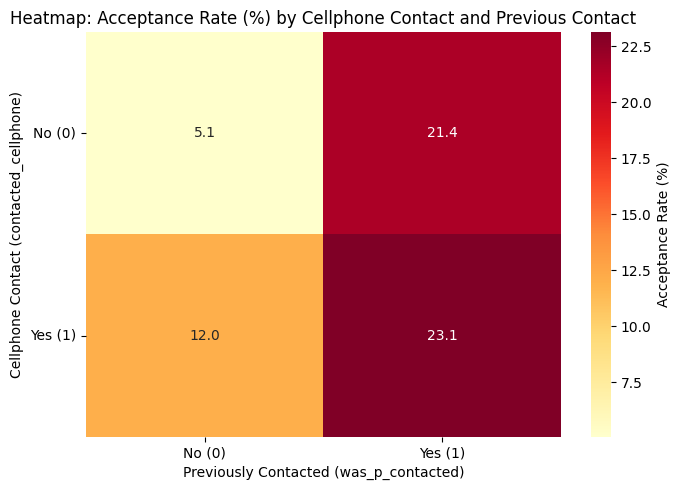

In [333]:
heatmap_table = df.groupby(['contacted_cellphone', 'was_p_contacted'])['response'].mean().unstack() * 100

plt.figure(figsize=(7,5))
sns.heatmap(
    heatmap_table,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={'label': 'Acceptance Rate (%)'}
)
plt.title('Heatmap: Acceptance Rate (%) by Cellphone Contact and Previous Contact')
plt.xlabel('Previously Contacted (was_p_contacted)')
plt.ylabel('Cellphone Contact (contacted_cellphone)')
plt.yticks([0.5, 1.5], ['No (0)', 'Yes (1)'], rotation=0)
plt.xticks([0.5, 1.5], ['No (0)', 'Yes (1)'])
plt.tight_layout()
plt.show()


- For clients who **have been previously contacted**, the **type of device does not affect** the acceptance rate. The probability of a positive response is similar regardless of the channel.  
- For clients who **have not been contacted before**, it is recommended to **prioritize cellphone contact**, as it increases the likelihood of acceptance.


#### Fifth Study: Previously Contacted Client × Housing Loan

- Question we want to answer:  
  **Do clients with a housing loan have a higher chance of acceptance if they were contacted in a previous campaign?**


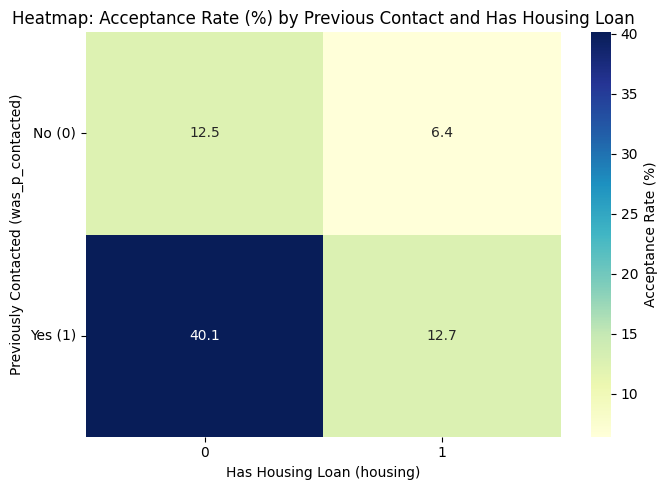

In [334]:
table_was_p_housing = df.groupby(['was_p_contacted', 'housing'])['response'].mean().unstack() * 100

plt.figure(figsize=(7, 5))
sns.heatmap(
    table_was_p_housing,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Acceptance Rate (%)'}
)
plt.title('Heatmap: Acceptance Rate (%) by Previous Contact and Has Housing Loan')
plt.xlabel('Has Housing Loan (housing)')
plt.ylabel('Previously Contacted (was_p_contacted)')
plt.yticks([0.5, 1.5], ['No (0)', 'Yes (1)'], rotation=0)
plt.tight_layout()
plt.show()


- For clients **with a housing loan**, the probability of accepting the offer is **very low**, so **even previous contacts do not significantly increase acceptance**.  
- For clients **without a housing loan**, the chance of acceptance **increases considerably** when they have been contacted before.


## 7. Conclusion

The analysis identified the main factors influencing clients' acceptance of term deposit offers, revealing important patterns for strategy planning.

### Key Insights:

1. **Call Duration (`duration`)**
   - This is the most determining factor, showing the highest positive correlation with response.  
   - Longer calls, especially above 360 seconds, substantially increase the conversion rate.  
   - The effect is even more pronounced for clients who had been contacted previously.

2. **Previous Contact History (`previous`)**
   - Clients contacted in prior campaigns show **more than double the acceptance rate** compared to those never contacted.  
   - There is a limit: **excessive contacts (11 or more)** tend to reduce effectiveness, although long conversations can still recover part of the conversion.

3. **Contact Channel (`contact_cellphone`)**
   - Calls to mobile phones increase the probability of acceptance **for clients without prior contact**.  
   - For previously contacted clients, the channel **does not significantly affect** the outcome.

4. **Financial and Personal Characteristics**
   - **Bank Balance (`balance`)**: clients with higher balances, especially above 3,000 BRL, have higher acceptance rates.  
   - **Housing Loan (`housing`)**: clients with an active mortgage are less likely to accept, a trend not offset by prior contact.  
   - **Occupation (`job`)**: students, retirees, and unemployed clients have a higher propensity to accept, whereas operational roles like blue-collar and housemaid tend to refuse.  
   - **Education Level (`edu_num`)**: acceptance rate increases as education level rises.  
   - **Number of Contacts in the Same Campaign (`campaign`)**: acceptance decreases as the client is contacted more times within the same campaign.

5. **Low-Impact Variables**
   - Age, salary, personal loans, and default status showed very low correlations and are not priority factors for direct segmentation.

### Recommended Strategy

- **Prioritize clients with a history of previous contact**, especially with **long call durations (360–657 seconds)**.  
- **Focus on mobile calls** for clients without prior contact.  
- **Avoid excessive attempts** within the same campaign to prevent saturation.  
- **Segment by profile**: clients with high balance, no housing loan, higher education, and occupations associated with higher acceptance (students, retirees, unemployed).

In summary, the analysis provides clear guidance to **optimize resources, improve conversion rates, and reduce unproductive efforts**, allowing the company to target actions more effectively and efficiently.


In [335]:
df.to_csv('data/bank_customers_processed.csv', index=False)
print("File 'data/bank_customers_processed.csv' successfully generated.")


File 'data/bank_customers_processed.csv' successfully generated.
